# An Analysis of Wind Speeds in the North Sea

---

### Data

We will be working with [data](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/) collected by [DWD](https://dwd.de) on Helgoland in a 10-minute intervall from 1996 to 2022. For loading the data, we have to manually collect the from a http server.


### Imports and Usage

You can simply use the `environment.yml` file to create a new conda environment with all the needed packages by running `conda env create -f environment.yml`. The only relevant parameter you may want to change is `RELOAD`. If set to `True`, all the needed data will be downloaded and saved in the `data/` folder.

## Data Loading

In [81]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime as dt
import matplotlib.dates as mdt
from tueplots import bundles
import tueplots as tp
import math
import scipy.optimize as opt
import scipy
from sklearn.gaussian_process import GaussianProcessRegressor as GP
import sklearn.gaussian_process.kernels as GPK

import sys
sys.path.append("../util/")
from dataloader import Loader
from weibull import Weibull
from dates import days_to_date


plt.rcParams.update(bundles.beamer_moml())
plt.rcParams['figure.dpi'] = 400
plt.rcParams["font.family"] = "DejaVu Sans"

# set true to download the data and unzip into the current directory
RELOAD = False
ZIP_NAME = "data.zip"
DATA_FOLDER = "../data"

DATA_BASE_URL = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/"
METRICS = ["wind", "air_temperature", "precipitation", "solar"]
METRIC_URLS = [DATA_BASE_URL + postfix + "/historical/" for postfix in METRICS]
print(METRIC_URLS)

['https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/wind/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/air_temperature/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/precipitation/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/solar/historical/']


In [82]:
loader = Loader(METRICS, DATA_FOLDER)
metric_files = loader.download_all_metrics(reset=False)

for kind in METRICS:
    print(f"Files containing {kind} data:\n\t{metric_files[kind]}")

kind_df, df = loader.as_dataframe

Files containing wind data:
	['c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\wind\\produkt_zehn_min_ff_19961220_19991231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\wind\\produkt_zehn_min_ff_20000101_20091231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\wind\\produkt_zehn_min_ff_20100101_20191231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\wind\\produkt_zehn_min_ff_20200101_20221231_02115.txt']
Files containing air_temperature data:
	['c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\air_temperature\\produkt_zehn_min_tu_19961219_19991231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\air_temperature\\produkt_zehn_min_tu_20000101_20091231_02115.txt', 'c:\\Users\\gwend\\Uni\\WiSe23\\DataLiteracy\\DataLiteracyProject\\data\\air_temperature\\produkt_zehn_min_tu_20100101_20191231_02115

In [83]:
# print(df.dtypes)
for metric, metric_df in kind_df.items():
    print(metric_df.dtypes)

STATIONS_ID             int64
MESS_DATUM     datetime64[ns]
  QN_wind               int64
FF_10_wind            float64
DD_10_wind              int64
eor_wind               object
dtype: object
STATIONS_ID                        int64
MESS_DATUM                datetime64[ns]
QN_air_temperature               float64
PP_10_air_temperature            float64
TT_10_air_temperature            float64
TM5_10_air_temperature           float64
RF_10_air_temperature            float64
TD_10_air_temperature            float64
  QN_air_temperature             float64
eor_air_temperature               object
dtype: object
STATIONS_ID                          int64
MESS_DATUM                  datetime64[ns]
QN_precipitation                   float64
RWS_DAU_10_precipitation             int64
RWS_10_precipitation               float64
RWS_IND_10_precipitation             int64
  QN_precipitation                 float64
eor_precipitation                   object
dtype: object
STATIONS_ID             

## Preprocessing

In [84]:
wind_df = kind_df["wind"]
wind_df["year"] = wind_df["MESS_DATUM"].dt.year
wind_df["month"] = wind_df["MESS_DATUM"].dt.month
wind_df["day"] = wind_df["MESS_DATUM"].dt.day

# First, get rid of NaNs

# a bit more than one year across all years is missing (~ 58000 days)
print(f"#NaNs: {wind_df['FF_10_wind'].isna().sum()}")
print(wind_df[(wind_df["FF_10_wind"].isna())].groupby("year")["STATIONS_ID"].agg("count").reset_index())
wind_df.dropna(subset=["FF_10_wind"], inplace=True)
wind_df = wind_df[wind_df["FF_10_wind"] != -999]

#NaNs: 0
Empty DataFrame
Columns: [year, STATIONS_ID]
Index: []


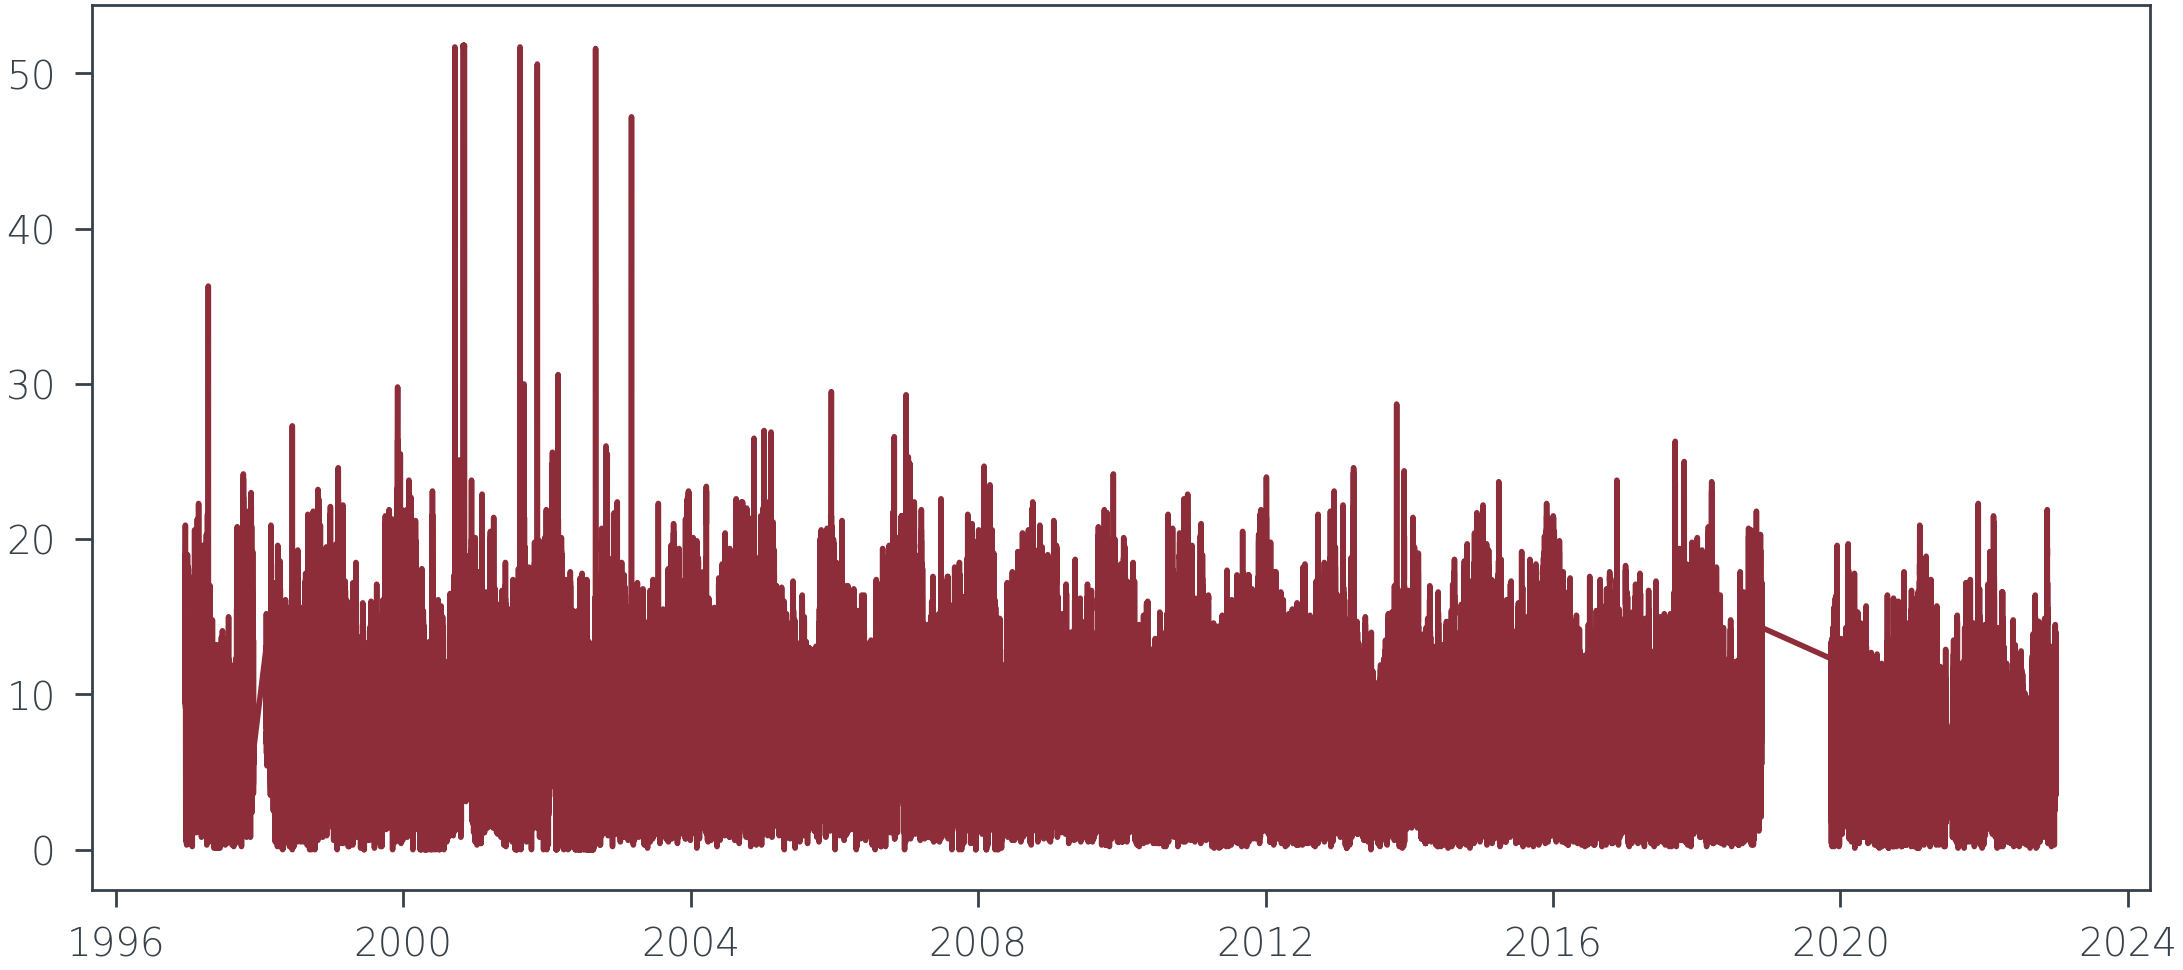

In [85]:
# there are still some outlier left
plt.plot("MESS_DATUM", "FF_10_wind", data=wind_df)
plt.show()

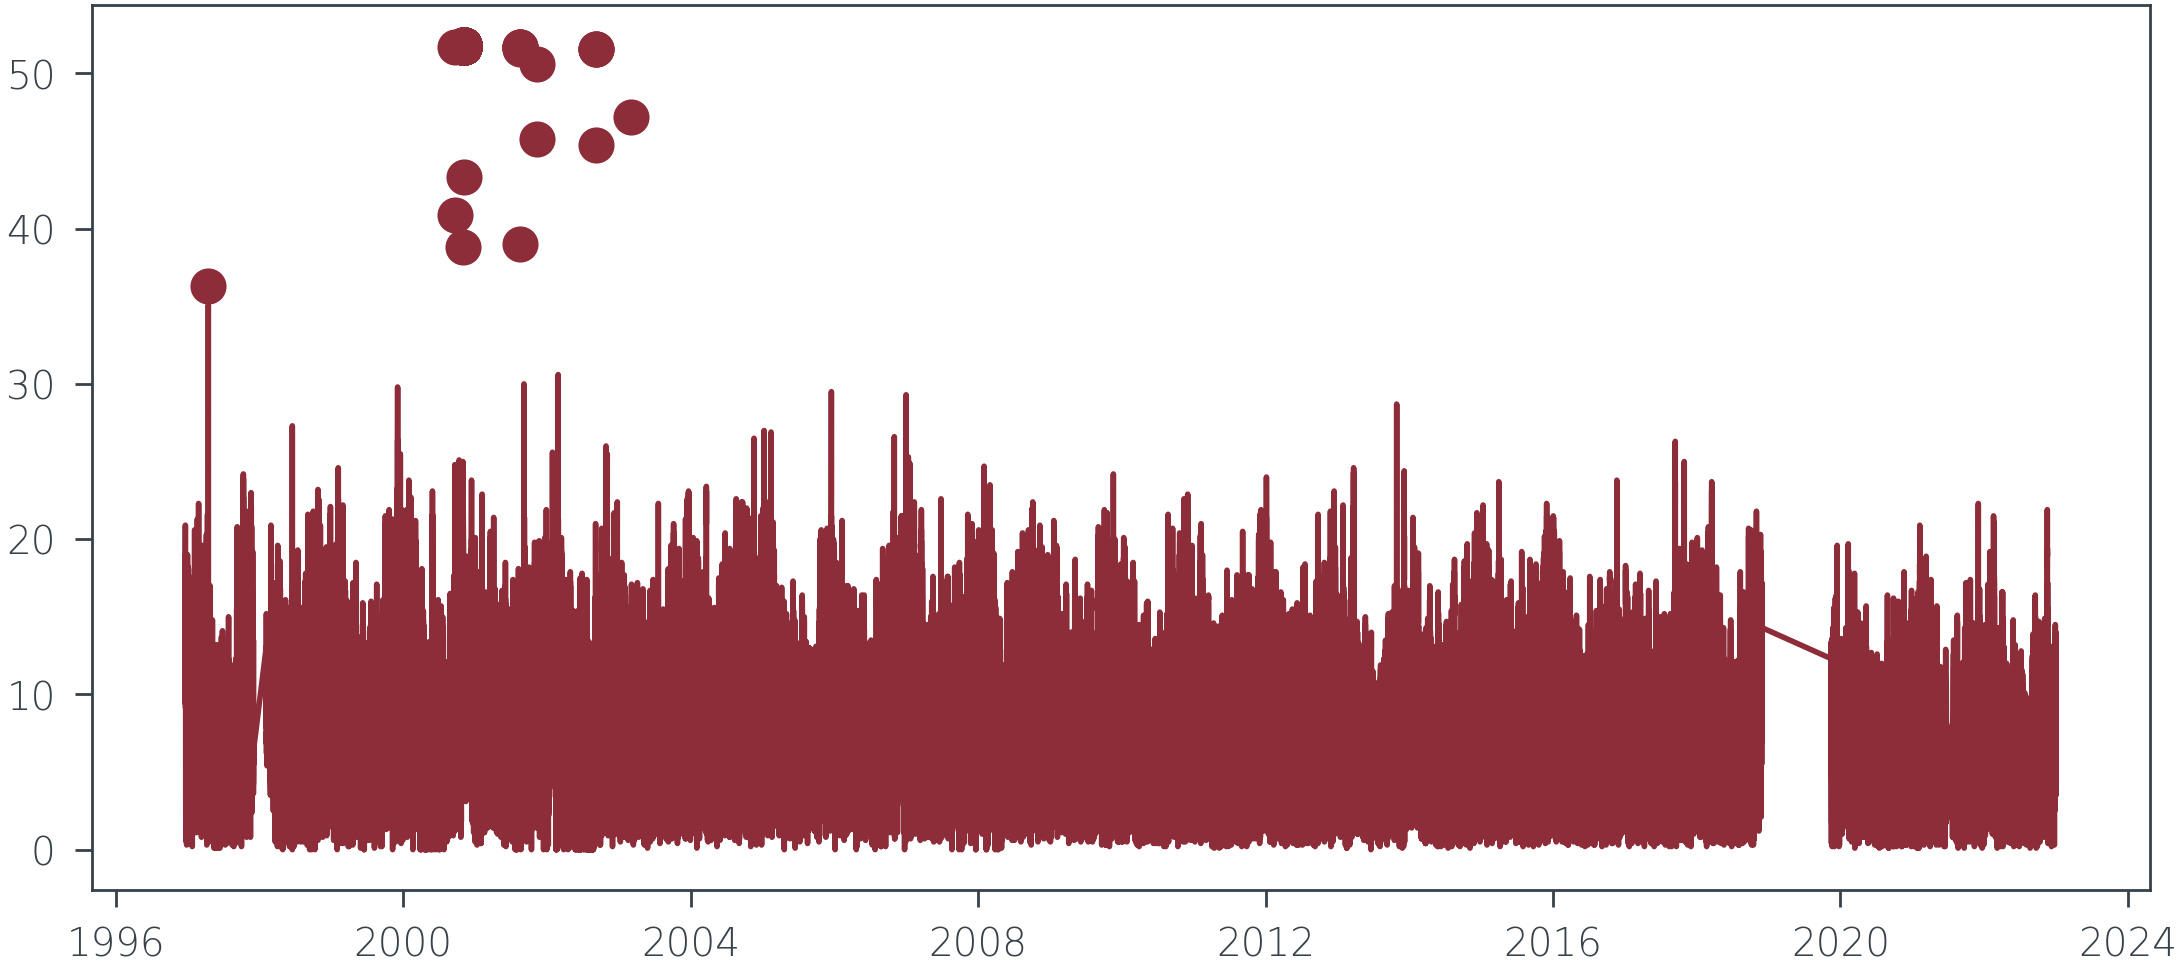

In [86]:
zscores = scipy.stats.zscore(wind_df["FF_10_wind"])
threshold = 7
plt.scatter("MESS_DATUM", "FF_10_wind", data=wind_df[zscores > threshold])
plt.plot("MESS_DATUM", "FF_10_wind", data=wind_df[zscores <= threshold])
wind_df = wind_df[zscores < 8]

## Explorative Data Analysis

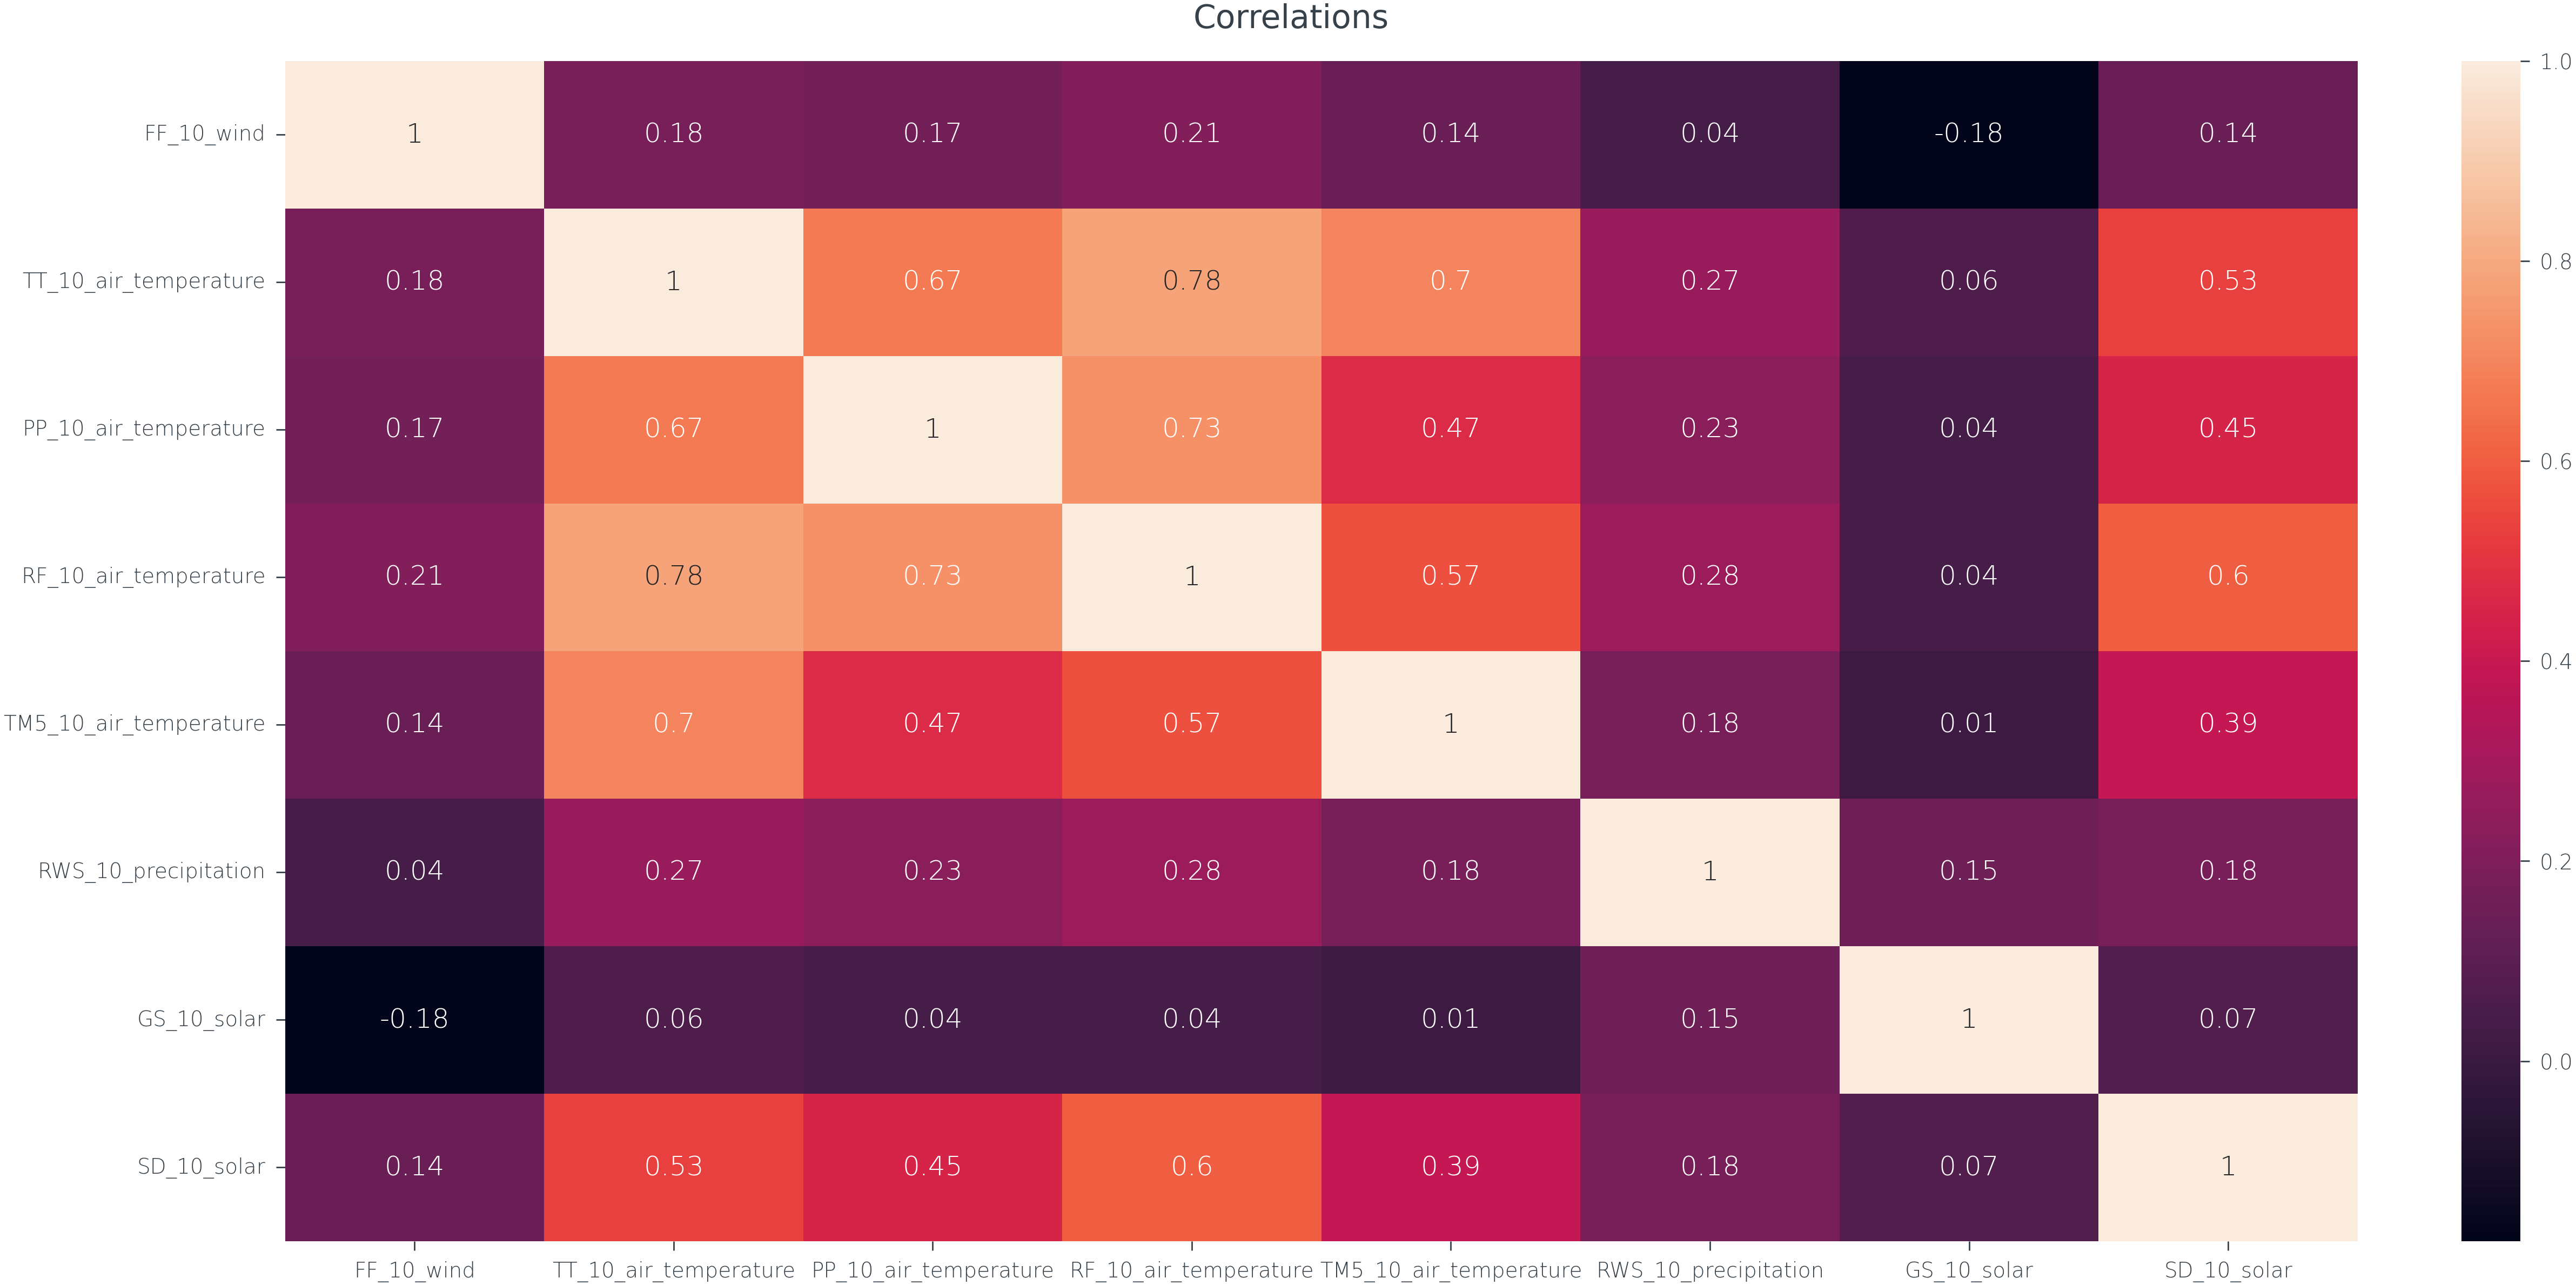

In [87]:
fig, ax = plt.subplots(figsize=(12, 6))
corr = df[["FF_10_wind", "TT_10_air_temperature", "PP_10_air_temperature", "RF_10_air_temperature", "TM5_10_air_temperature", "RWS_10_precipitation", "GS_10_solar", "SD_10_solar"]].corr().round(2)
ax = sns.heatmap(corr, annot=True)
fig.suptitle("Correlations")
plt.show()

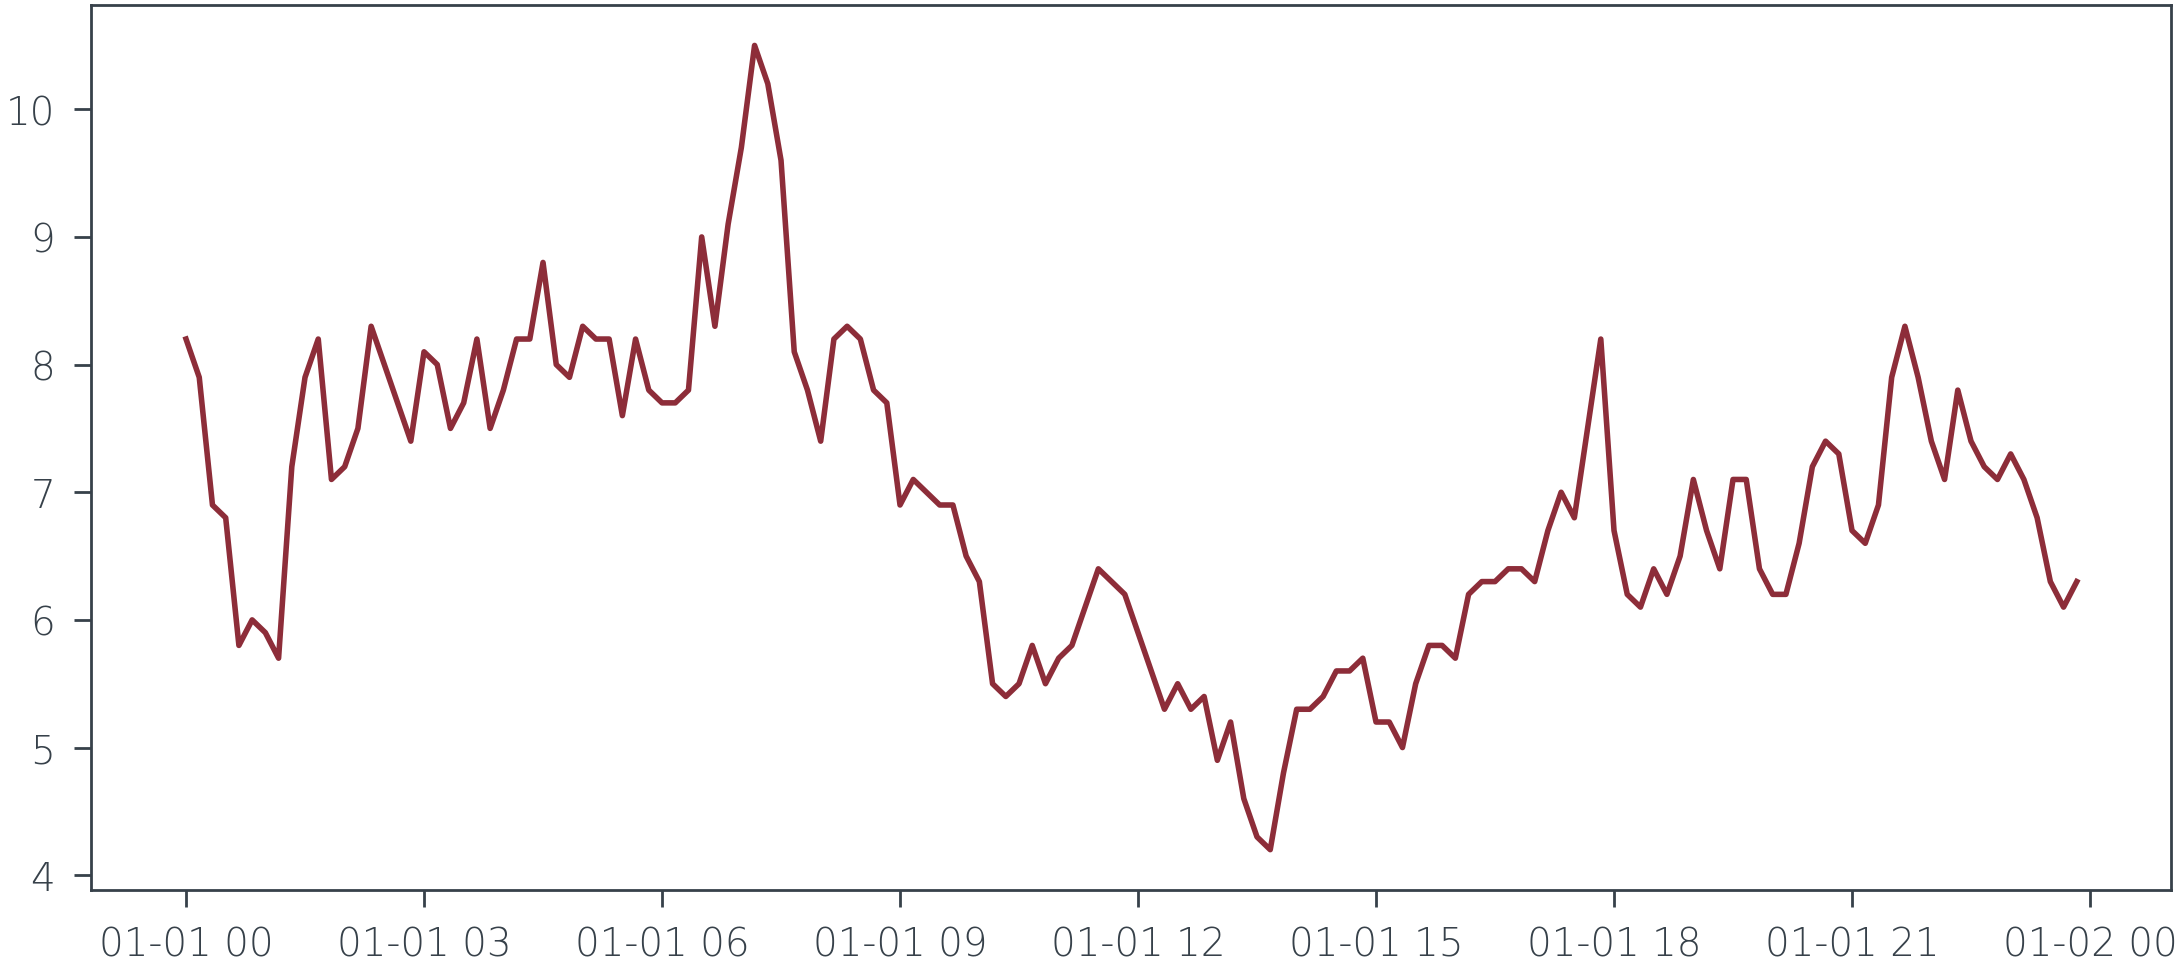

In [88]:
mask = (wind_df['MESS_DATUM'].dt.day == 1) & (wind_df['MESS_DATUM'].dt.month == 1) & (wind_df['MESS_DATUM'].dt.year == 2022)
plt.plot(wind_df[mask]["MESS_DATUM"], wind_df[mask]["FF_10_wind"])


C:\Users\gwend\AppData\Local\Temp\ipykernel_19340\1007860517.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


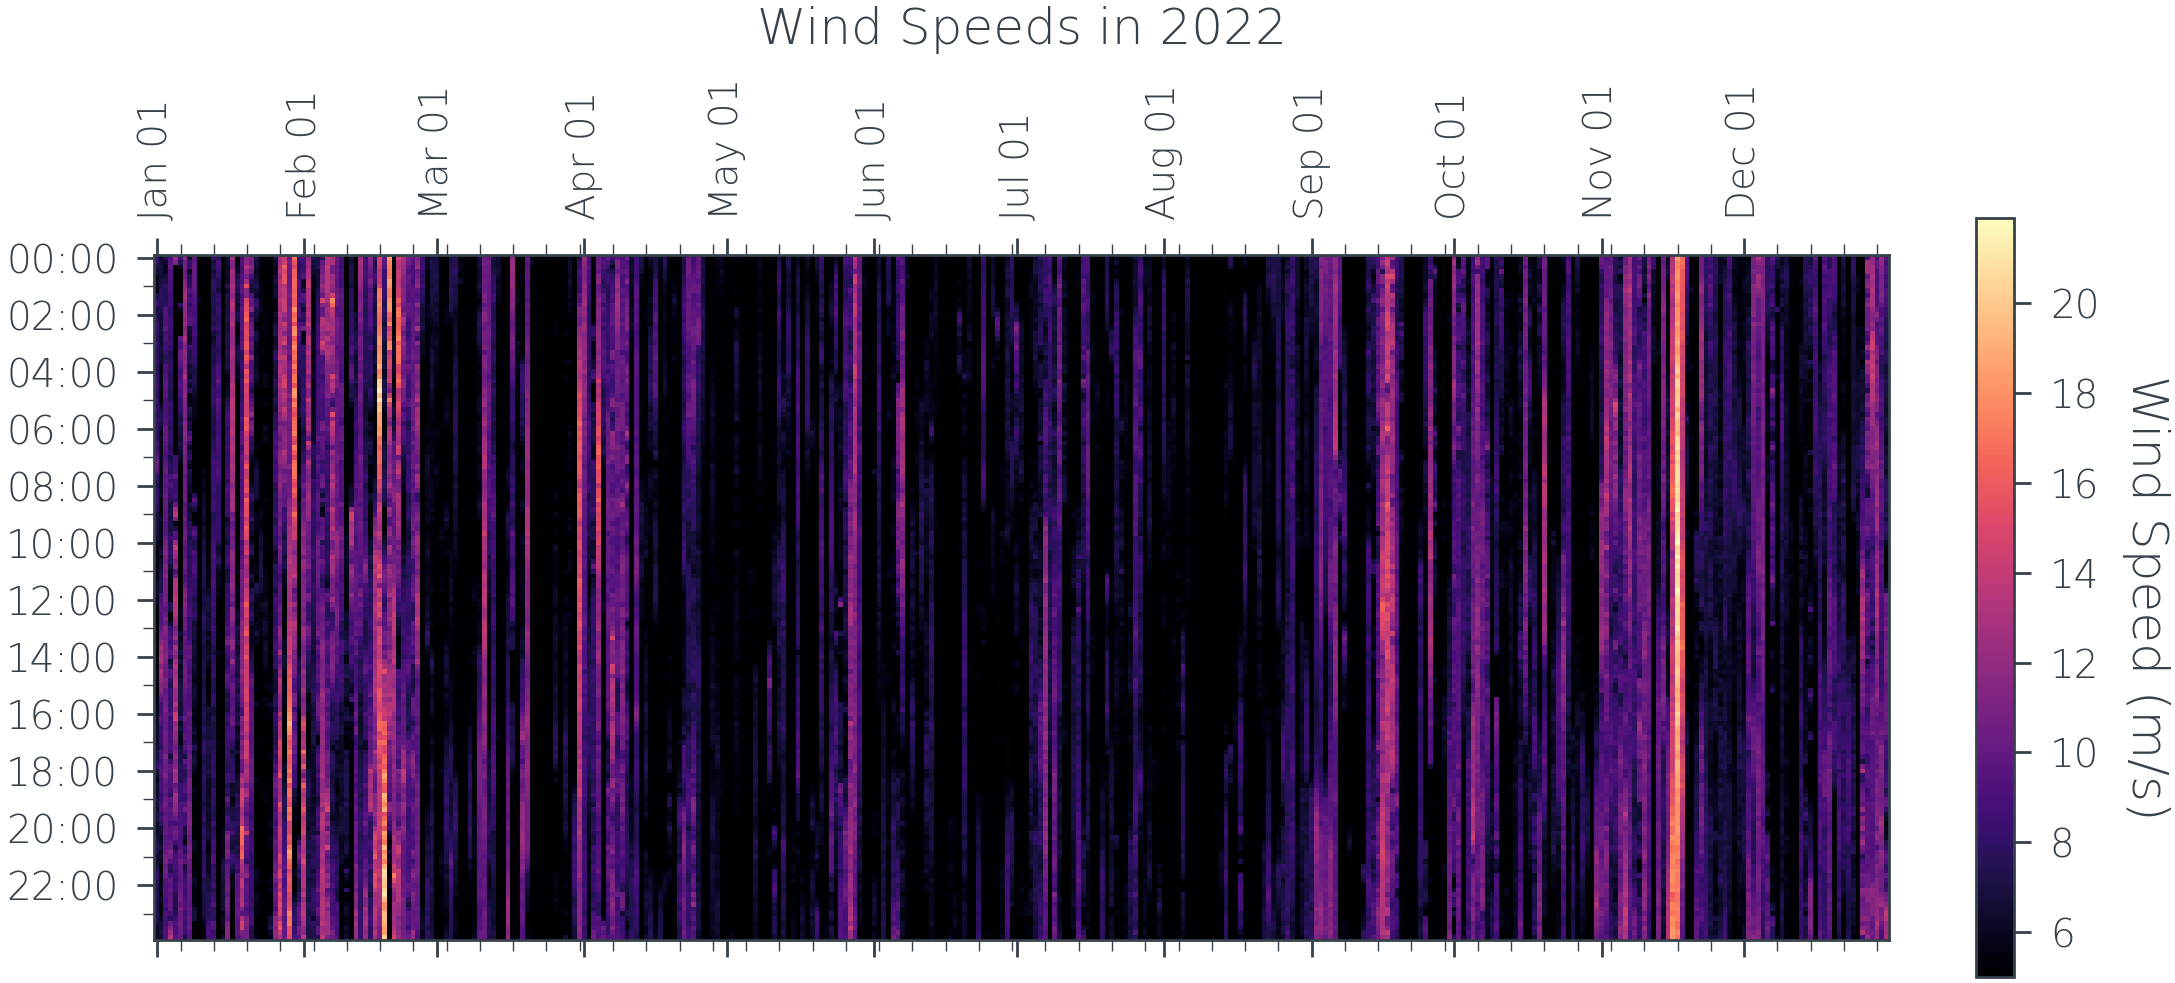

In [89]:
wind_df_2022 = wind_df[wind_df["MESS_DATUM"].dt.year == 2022].copy()
wind_df_2022["Day"] = wind_df_2022["MESS_DATUM"].dt.date
wind_df_2022["Time"] = wind_df_2022["MESS_DATUM"].dt.time

pivot_table_2022 = pd.pivot_table(
    wind_df_2022, values=("FF_10_wind"), index=["Time"], columns=["Day"], aggfunc="mean"
).fillna(0)

fig, ax = plt.subplots()
im = ax.matshow(pivot_table_2022, cmap="magma", vmin=5)

ax.set_yticks(np.arange(len(pivot_table_2022.index))[::12])
ax.set_yticks(np.arange(len(pivot_table_2022))[::6], minor=True)
ax.set_yticklabels([time.strftime("%H:%M") for time in pivot_table_2022.index[::12]])

ax.xaxis.set_major_locator(mdt.MonthLocator(interval=1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.xaxis.set_minor_locator(
    mdt.WeekdayLocator(interval=1)
)
date_form = mdt.DateFormatter("%b %d")
ax.xaxis.set_major_formatter(date_form)
# ax.grid(which="major", axis="x", linestyle="--", linewidth="0.5", color="gray")
# ax.grid(which="major", axis="y", linestyle="--", linewidth="0.5", color="gray")

cbar = ax.figure.colorbar(im, ax=ax, shrink=1.0)
cbar.ax.set_ylabel("Wind Speed (m/s)", rotation=-90, va="bottom")

ax.set_title("Wind Speeds in 2022")
plt.show()

Text(0.5, 0.98, 'Wind Speeds 2015-2022')

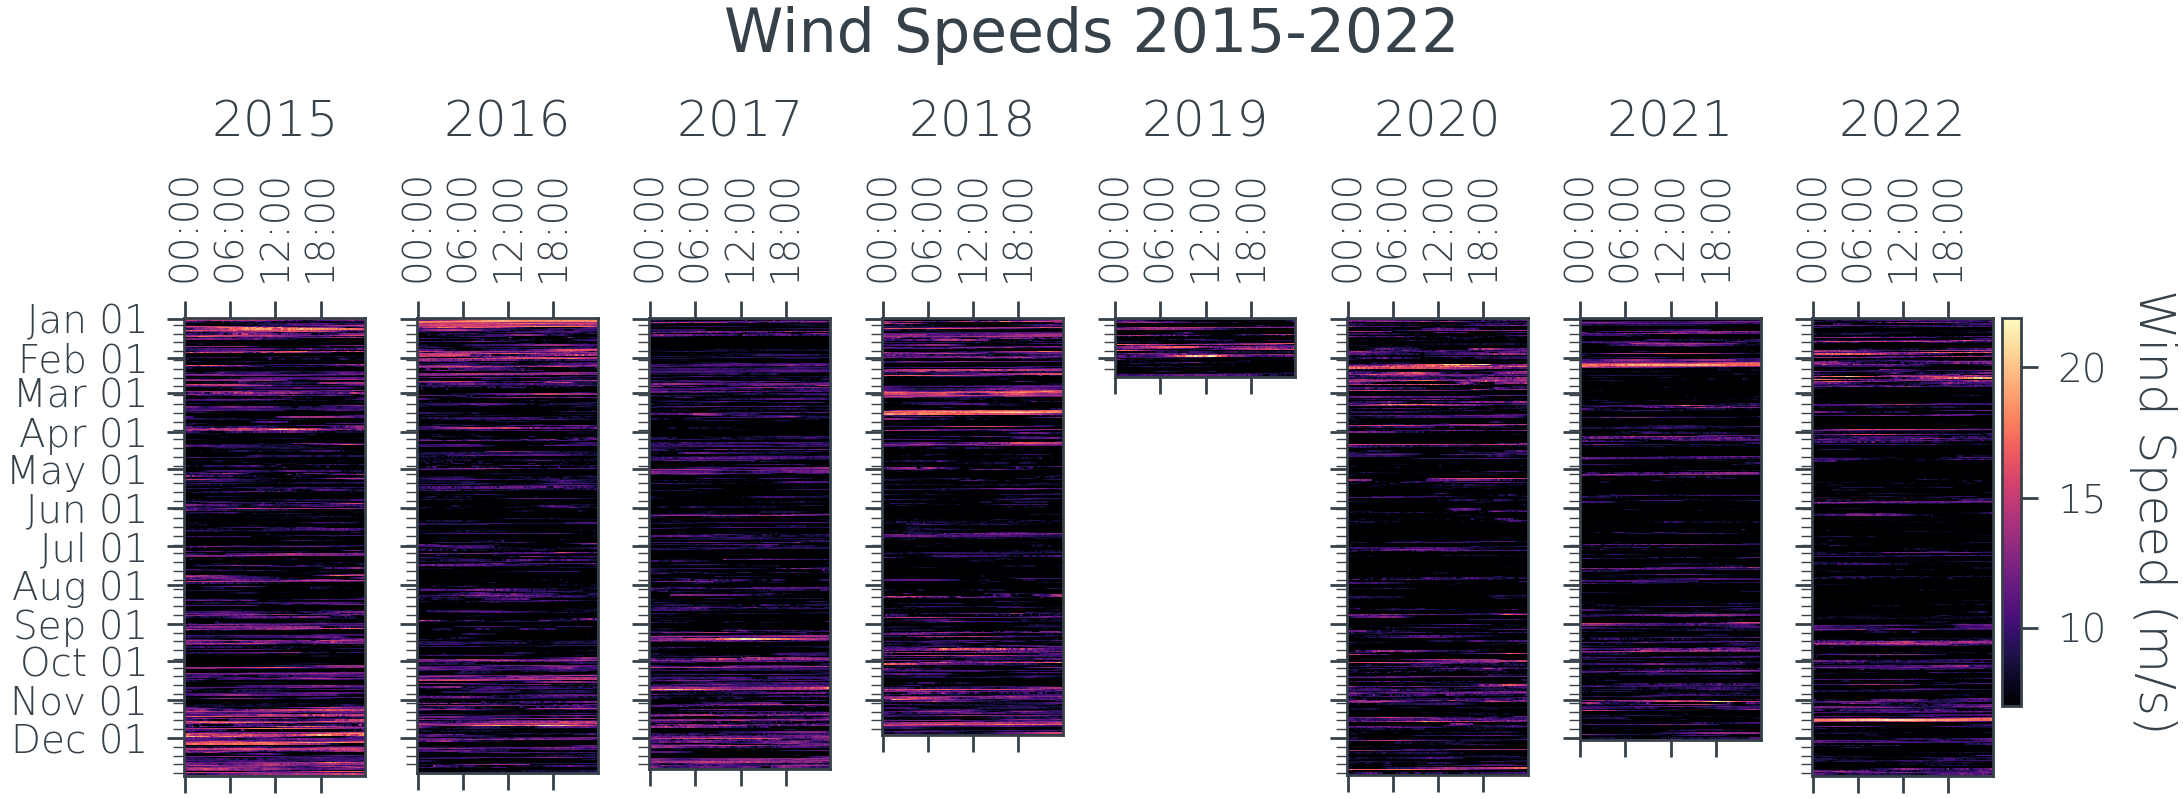

In [90]:
fig, axs = plt.subplots(1, 8, sharex=True, sharey=False)
# fig.suptitle("Wind Speeds in the years 2015-2022")

for i, year in enumerate(range(2015, 2023)):
    ax = axs[i]
    # ax.set_anchor("N")
    mask = wind_df["MESS_DATUM"].dt.year == year
    wind_df_year = wind_df[mask].copy()
    wind_df_year.fillna(0, inplace=True)

    wind_df_year["Day"] = wind_df_year["MESS_DATUM"].dt.date
    wind_df_year["Time"] = wind_df_year["MESS_DATUM"].dt.time

    pivot_table = pd.pivot_table(
        wind_df_year, values=("FF_10_wind"), index=["Day"], columns=["Time"], aggfunc="mean", fill_value=0
    )

    Daystrings = [date.strftime("%d %b") for date in pivot_table.index.values]
    TimeStrings = [time.strftime("%H:%M") for time in pivot_table.columns]

    im = ax.matshow(pivot_table, cmap="magma", vmin=7)

    ax.set_xticks(np.arange(len(pivot_table.columns))[:: (6 * 6)])
    ax.set_xticklabels(TimeStrings[:: (6 * 6)], rotation=90)
    ax.yaxis.set_major_locator(
        mdt.MonthLocator(interval=1)
    )
    ax.yaxis.set_minor_locator(
        mdt.WeekdayLocator(interval=1)
    )
    if i == 0:
        ax.yaxis.set_major_formatter(date_form)
    else:
        ax.set_yticklabels([])

    if i == 7:
        cbar = fig.colorbar(im, ax=ax, shrink=0.6, location="right", anchor=(0.0, 1.0))
        cbar.ax.set_ylabel("Wind Speed (m/s)", rotation=-90, va="bottom")

    ax.set_title(year)

for ax in axs:
    ax.set_anchor("N")
fig.suptitle("Wind Speeds 2015-2022")

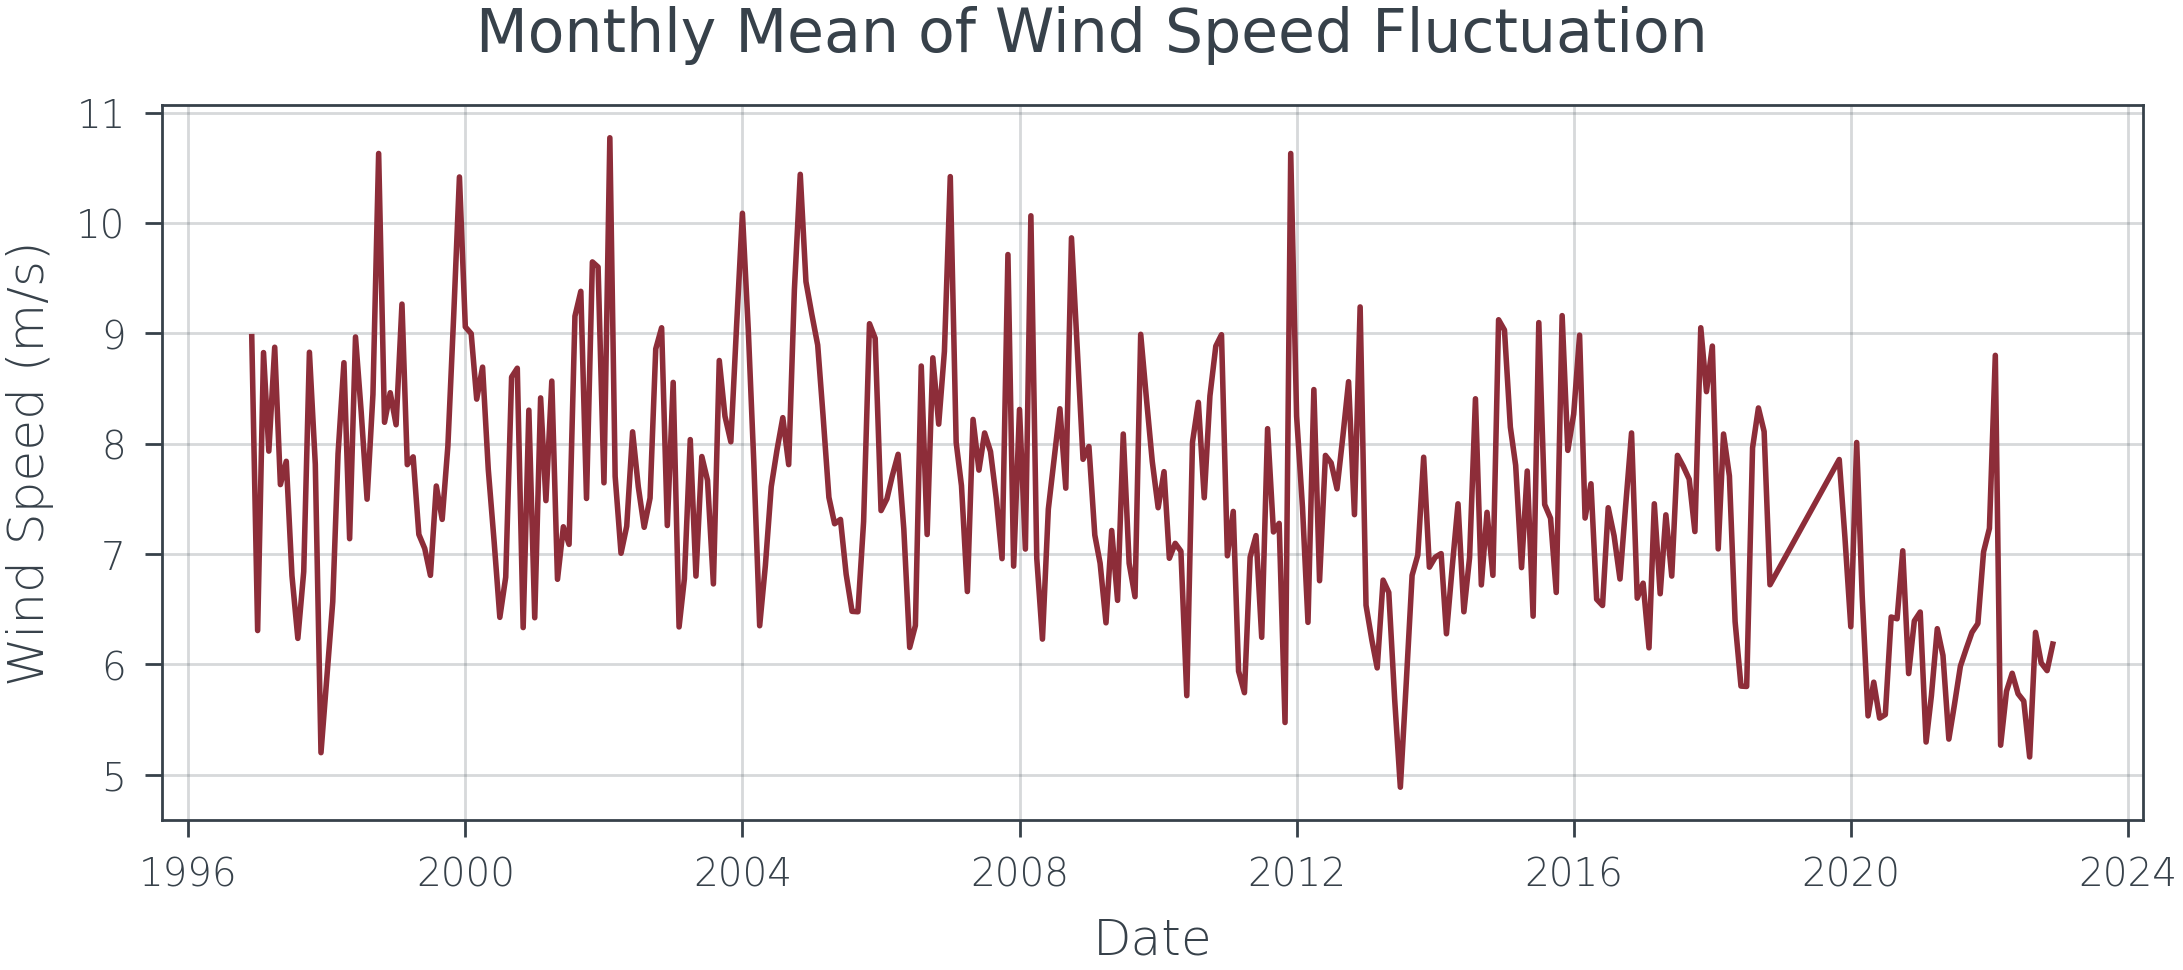

In [91]:
wind_df_by_year = wind_df.groupby(["year", "month", "day"])
wind_df_agg_yr = wind_df_by_year["FF_10_wind"].aggregate(["max", "min"])
wind_df_agg_yr["diff"] = wind_df_agg_yr["max"] - wind_df_agg_yr["min"]
wind_df_agg_yr.reset_index(inplace=True)
wind_df_agg_yr["date"] = pd.to_datetime(wind_df_agg_yr[["year", "month", "day"]])

wind_df_mean_diff = wind_df_agg_yr.groupby(["year", "month"])["diff"].mean().reset_index()
wind_df_mean_diff["date"] = pd.to_datetime(wind_df_mean_diff[["year", "month"]].assign(day=1))

fig, ax = plt.subplots(1, 1)
fig.suptitle("Monthly Mean of Wind Speed Fluctuation")
ax.plot(wind_df_mean_diff["date"], wind_df_mean_diff["diff"])
ax.set_ylabel("Wind Speed (m/s)")
ax.set_xlabel("Date")
ax.grid(which="major")

Text(0.5, 0.98, 'Monthly Mean of Wind Speed Fluctuations')

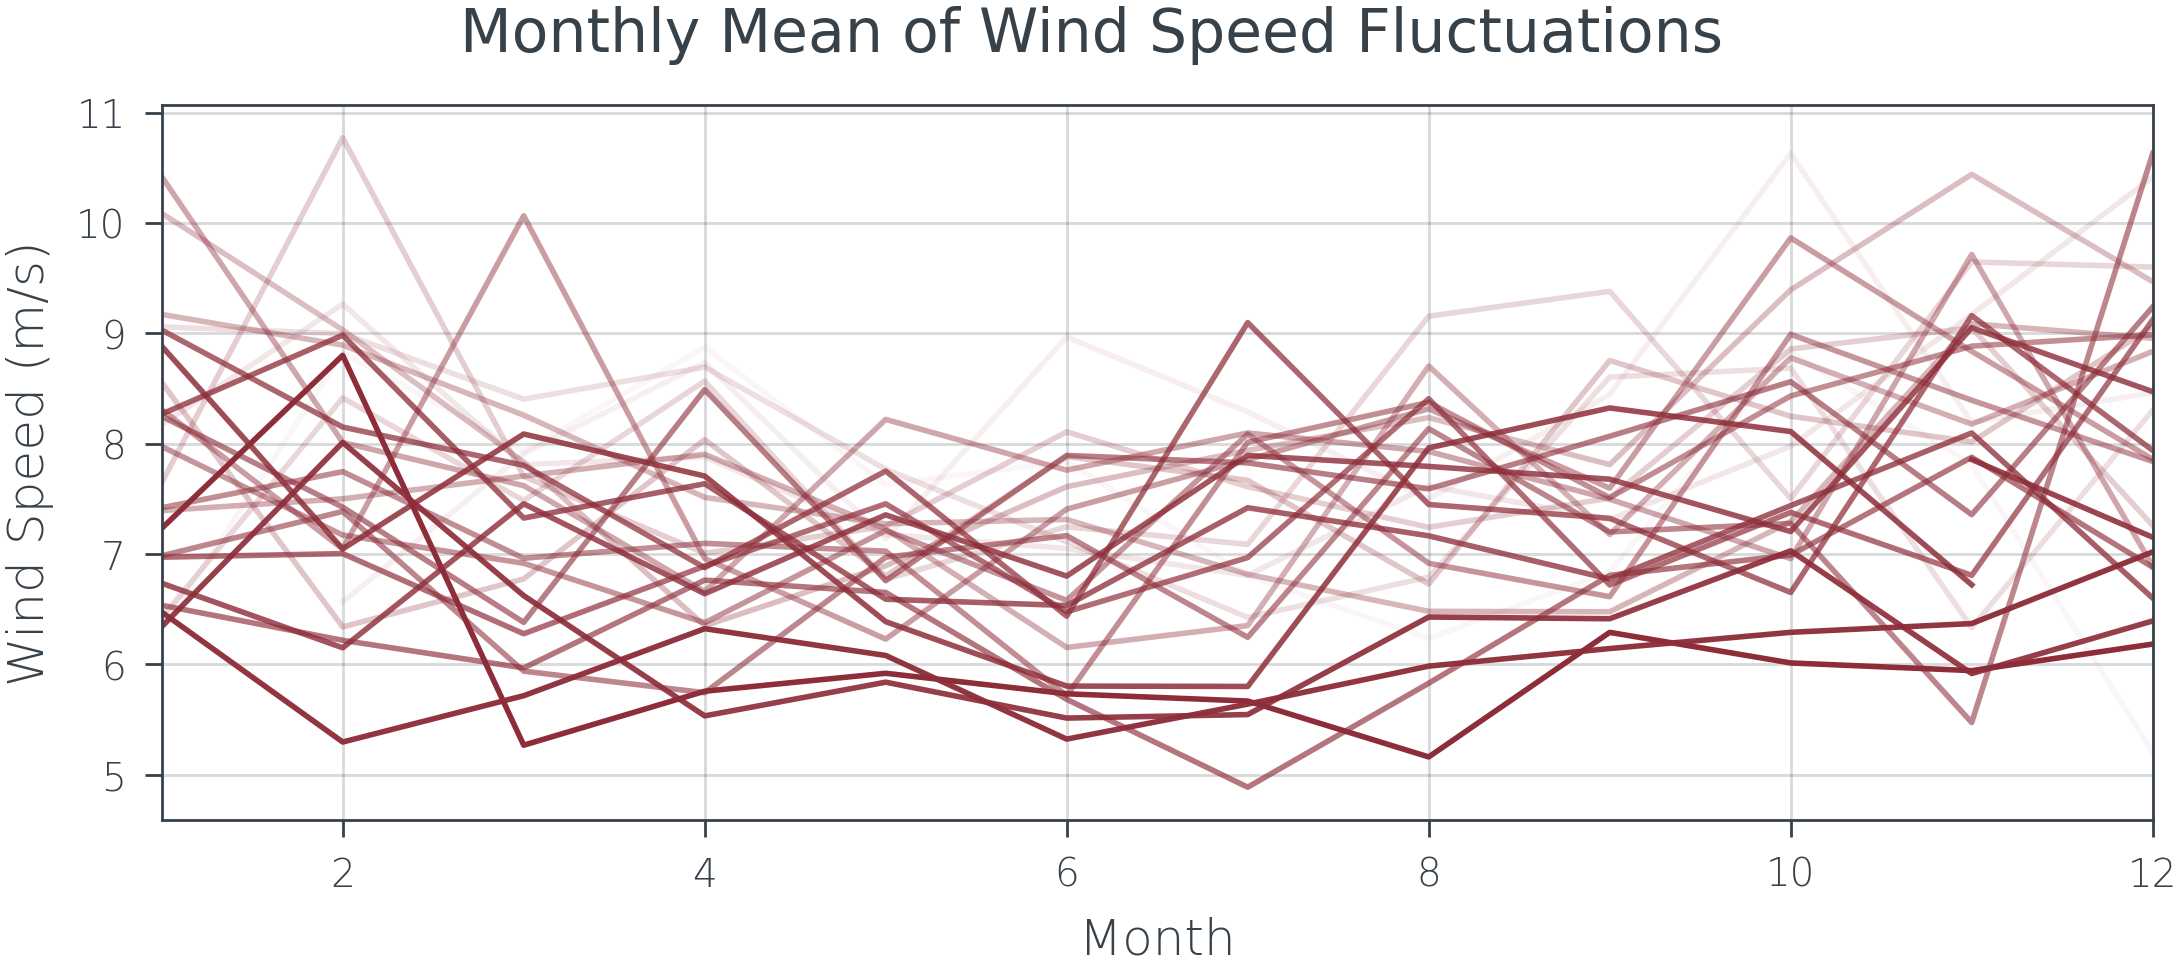

In [92]:
fig, axs = plt.subplots(1, 1)

for year, year_month_df in wind_df_mean_diff.groupby("year"):
    alpha = (year - 1996) / (2022 - 1996)
    axs.plot(year_month_df["month"], year_month_df["diff"], color=tp.constants.color.rgb.tue_red, alpha=alpha)
# sns.boxplot(data=wind_df_agg_yr, x=wind_df_agg_yr.index.values, y="diff")

axs.set_ylabel("Wind Speed (m/s)")
axs.set_xlabel("Month")
axs.set_xlim((1, 12))
axs.grid(which="major")
fig.suptitle("Monthly Mean of Wind Speed Fluctuations")
# wind_df_mean_diff.groupby("year")["diff"].plot(kind="kde", ax=axs[1])

Text(0.5, 0, 'Wind Speeds (m/s)')

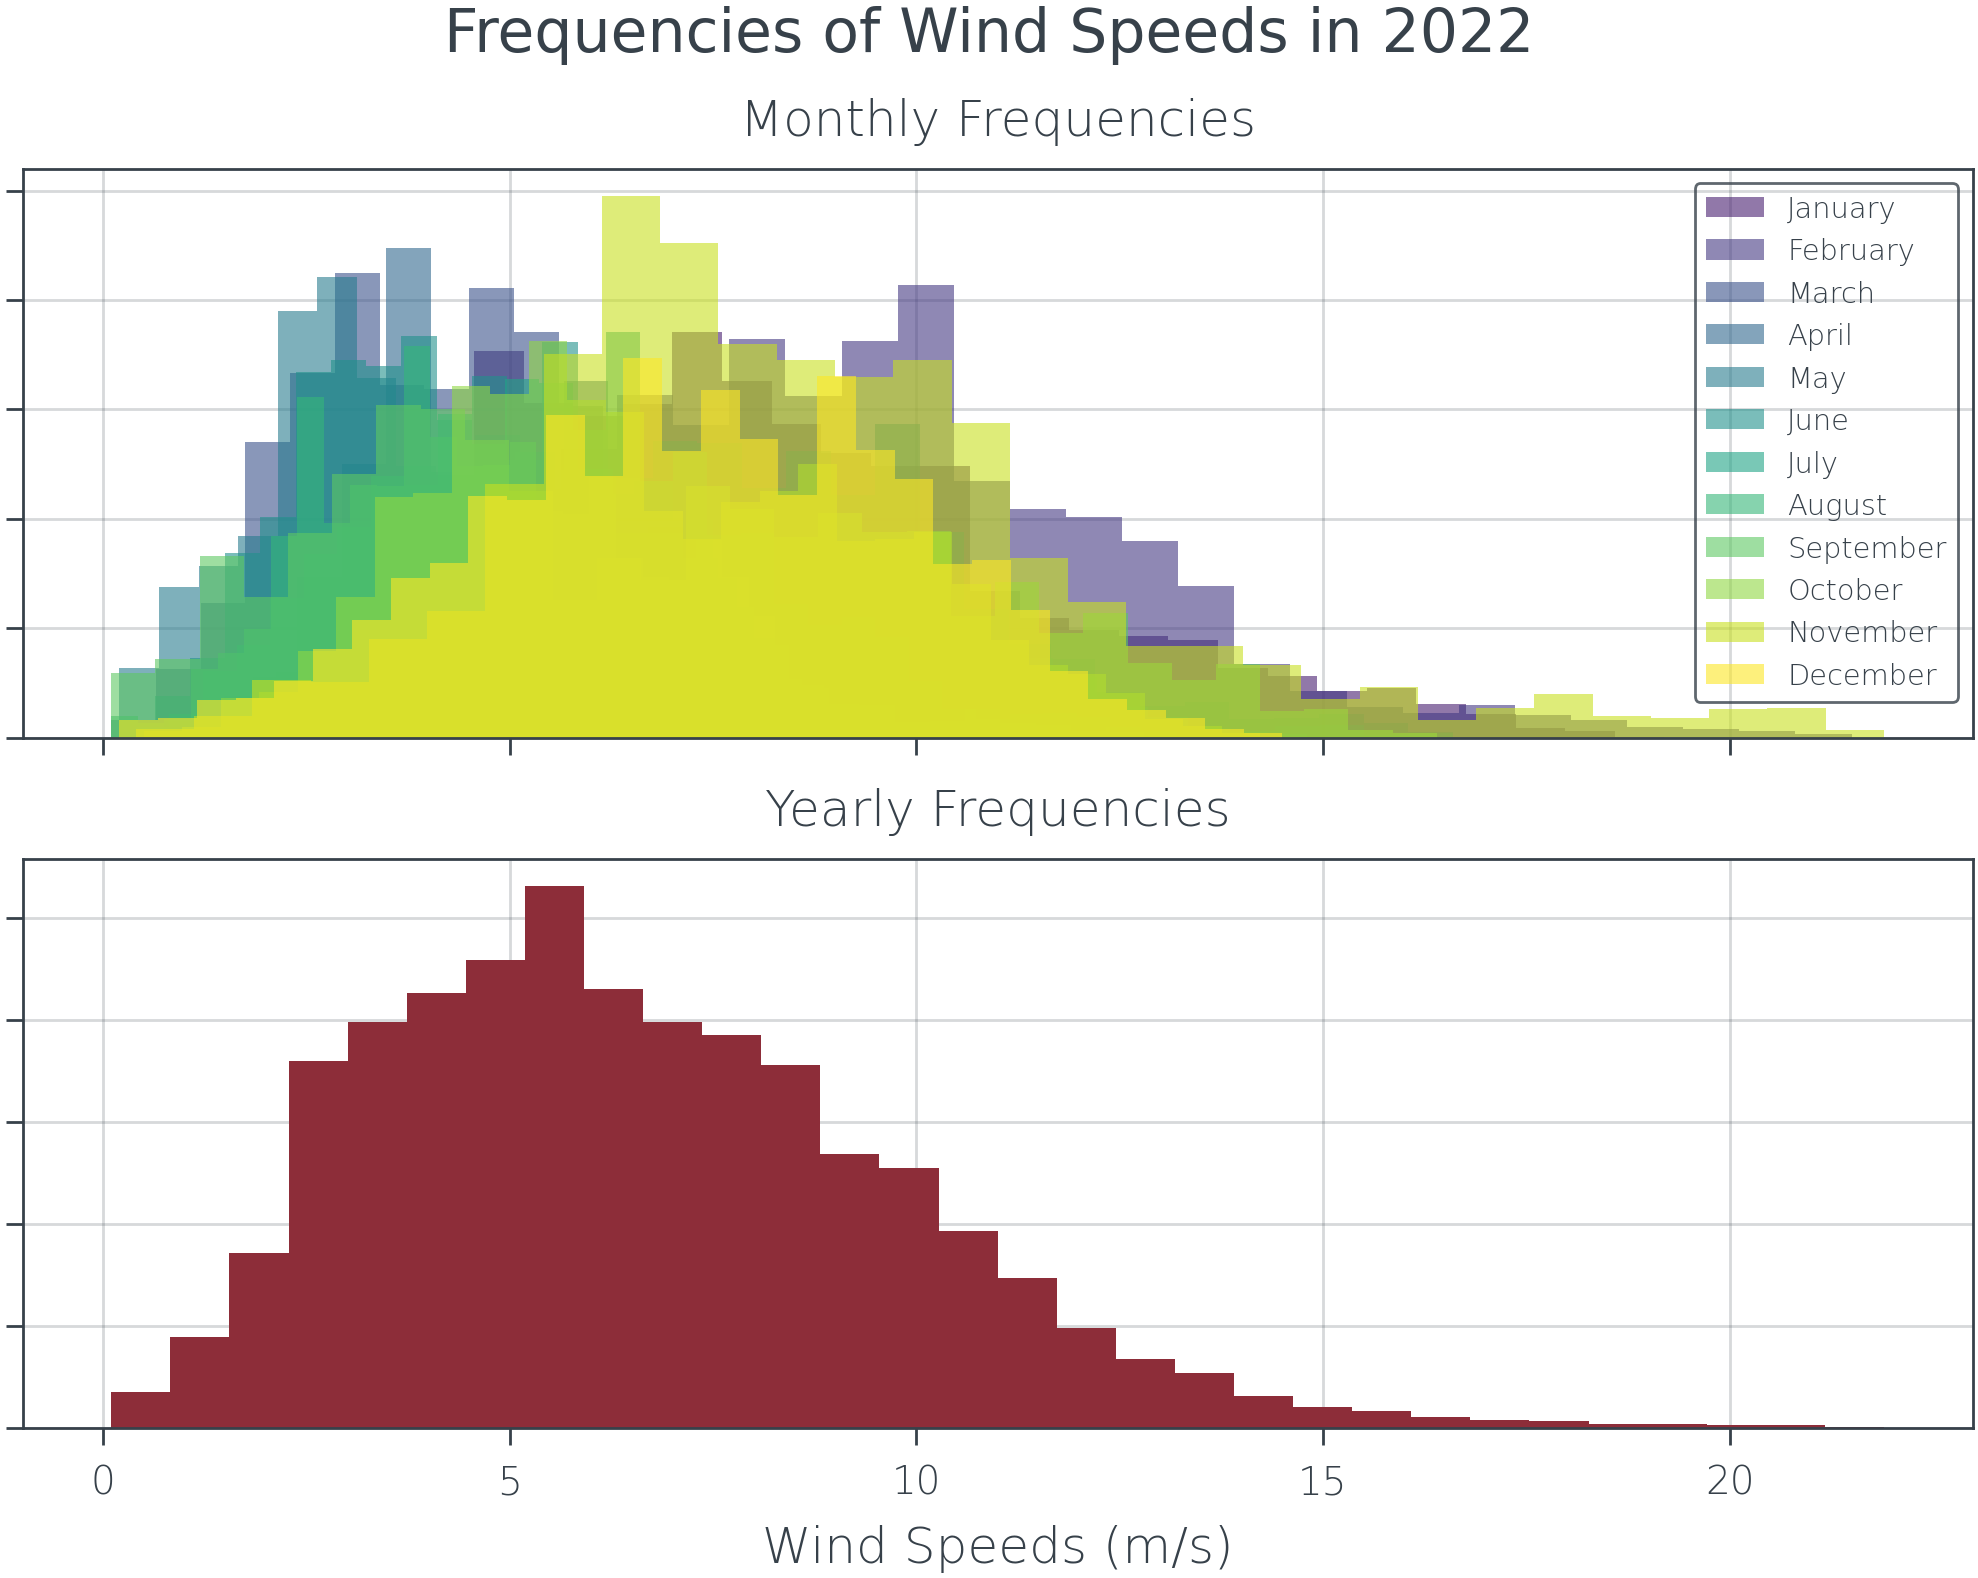

In [93]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 4))
# Create a list of colors for the colormap (here, we use a smooth transition from blue to red to blue)
colors = plt.cm.viridis(np.linspace(0, 1, 13))

fig.suptitle("Frequencies of Wind Speeds in 2022")
wind_df_2022["month"] = wind_df_2022["MESS_DATUM"].dt.month
for year, year_month_df in wind_df_2022.groupby("month"):
    year_month_df.hist(column="FF_10_wind", bins=30, ax=ax1, alpha=0.6, label=dt.datetime(2022, year, 1).strftime("%B"), color=colors[year])
# wind_df_2022[wind_df_2022["MESS_DATUM"].dt.month == 6].hist(column="FF_10_wind", bins=20, ax=ax)
ax1.set_title("")
ax1.set_yticklabels([])
# ax1.set_xlabel("Wind Speed (m/s)")
ax1.set_title("Monthly Frequencies")
ax1.legend(loc="upper right", fontsize="xx-small")

wind_df_2022.hist(column="FF_10_wind", bins=30, ax=ax2)
ax2.set_title("Yearly Frequencies")
ax2.set_yticklabels([])
ax2.set_xlabel("Wind Speeds (m/s)")

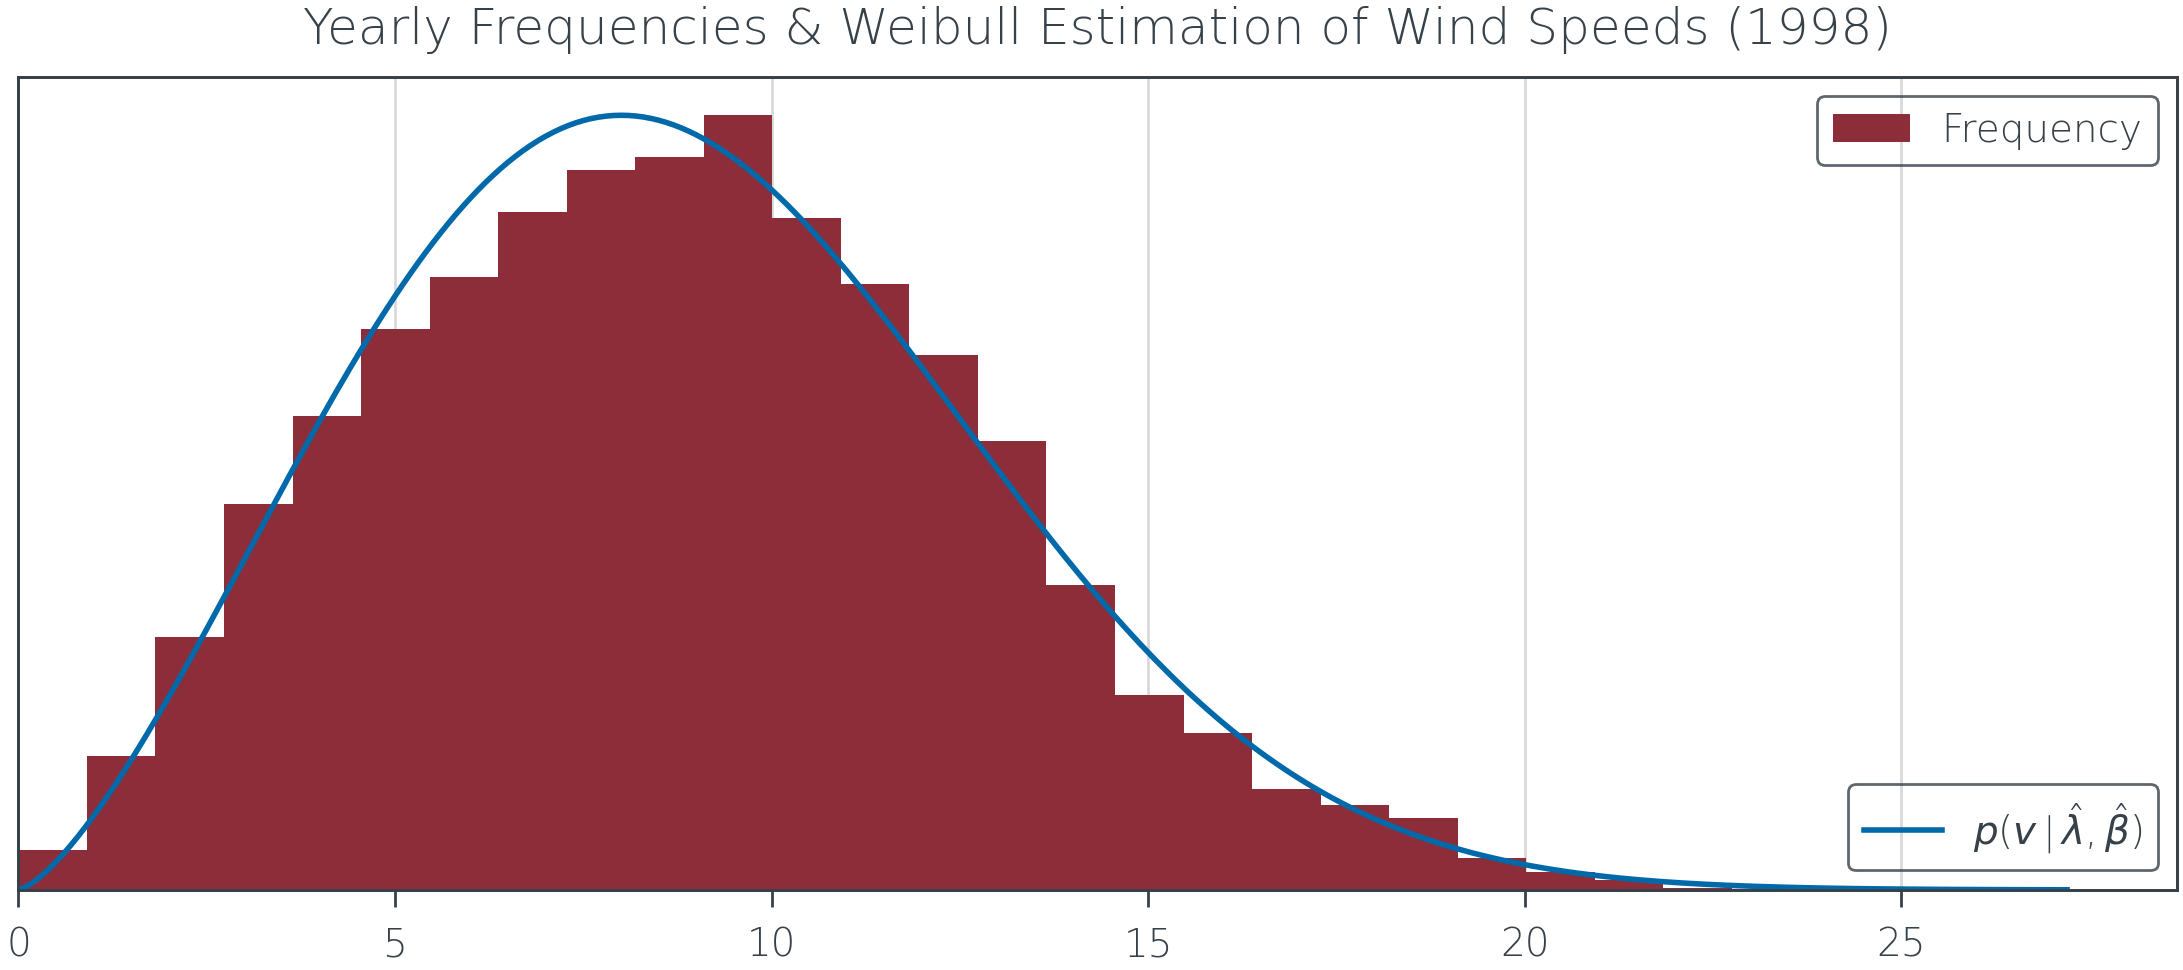

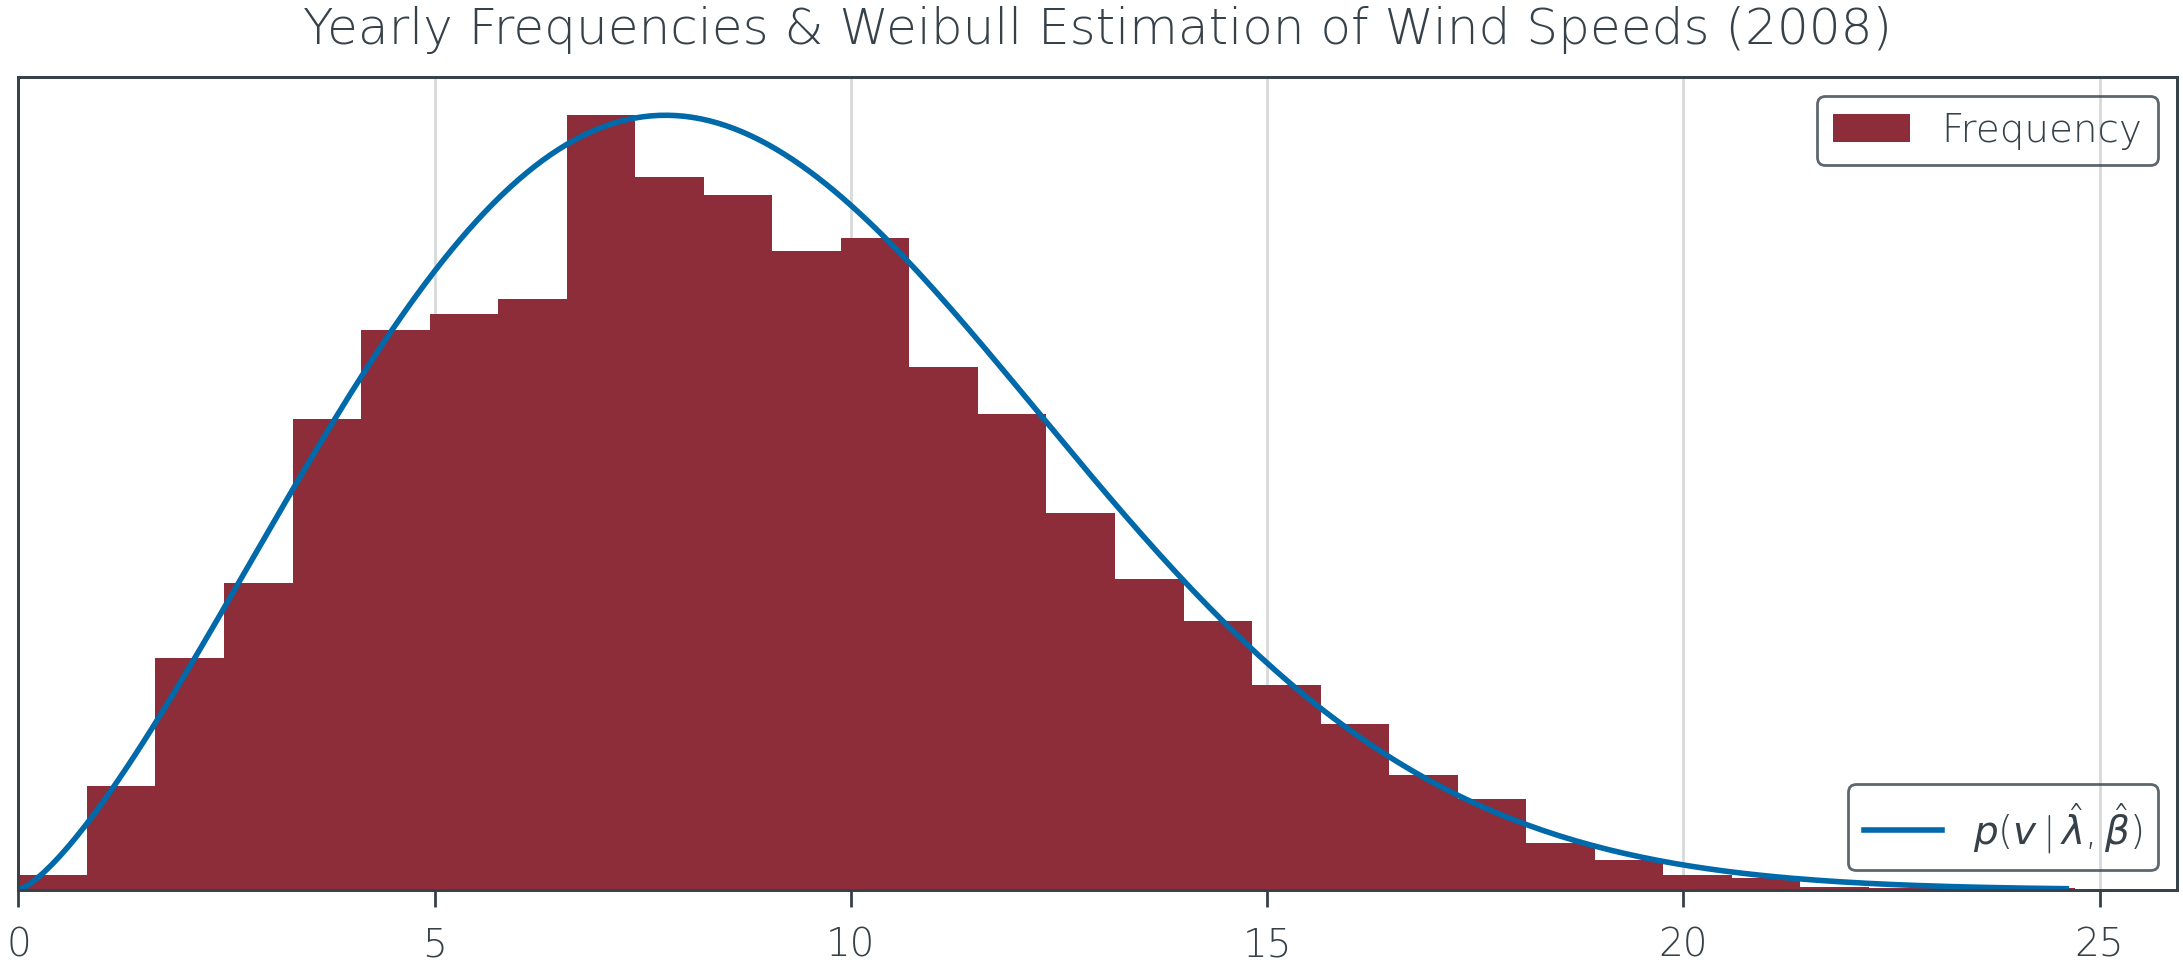

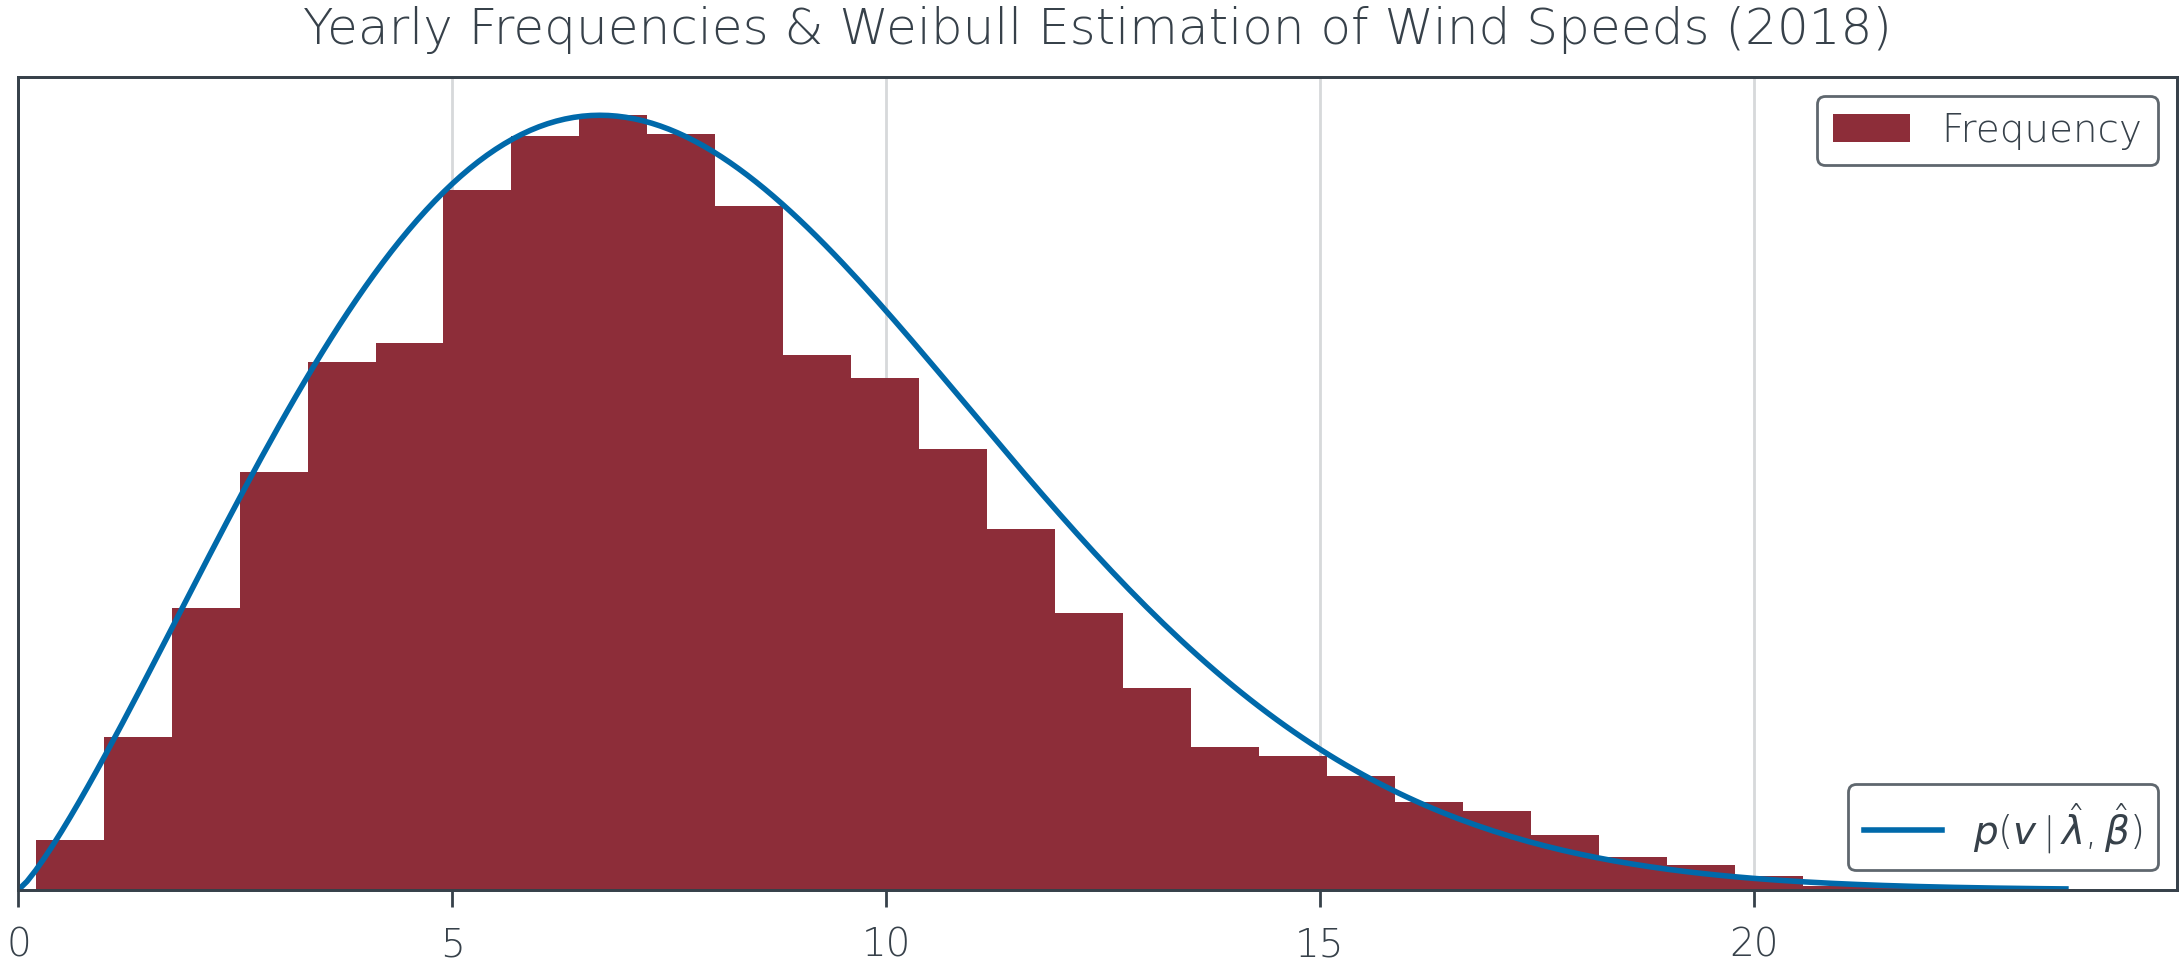

In [94]:
def plot_year(year, ax):
    year_df = wind_df[wind_df["MESS_DATUM"].dt.year == year]
    year_df_wind_mean = year_df["FF_10_wind"].mean()
    Y = year_df["FF_10_wind"].dropna().to_numpy()
    
    weibull = Weibull.estimate(Y)
    X = np.arange(0, np.max(Y), 0.1)

    ax1 = ax.twinx()
    ax1.plot(X, weibull.pdf(X), color=tp.constants.color.rgb.tue_blue, label=r"$p(v \mid \hat{\lambda}, \hat{\beta})$")
    ax1.set_ylim(0)
    ax1.set_yticklabels([])
    ax1.set_yticks([])
    ax1.legend(loc="lower right")


    year_df.hist(column="FF_10_wind", bins=30, ax=ax, color=tp.constants.color.rgb.tue_red, label="Frequency")
    ax.set_title("")
    ax.set_xlim(0)
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.legend(loc="upper right")
    ax.set_title(f"Yearly Frequencies & Weibull Estimation of Wind Speeds ({year})")

# year with invalid measurements
#fig, ax = plt.subplots()
#plot_year(2000, ax)

years = range(1998, 2023, 10)
for year in years:
    fig, ax = plt.subplots(1, 1)
    plot_year(year, ax)
plt.show()

Text(0, 0.5, '$p(v \\mid \\hat{\\lambda}, \\hat{\\beta})$')

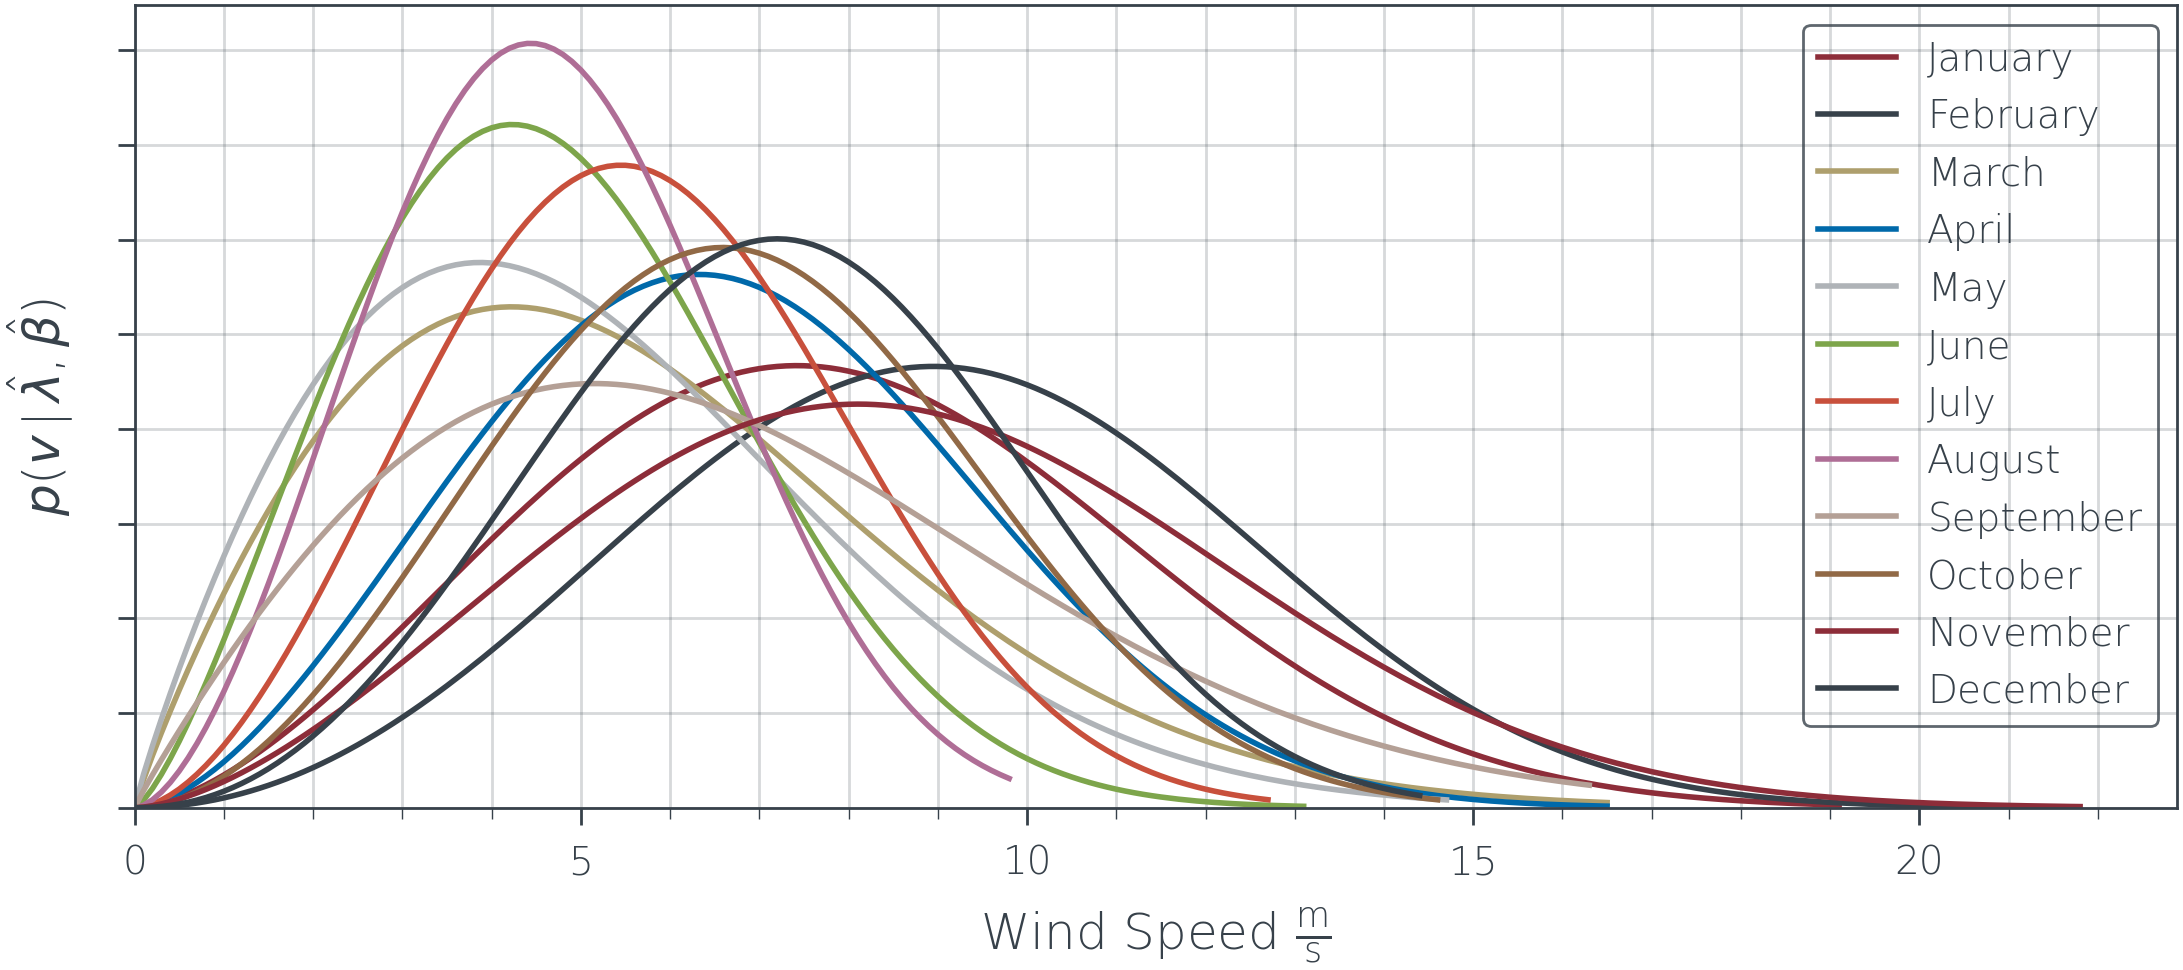

In [95]:
fig, ax = plt.subplots(1, 1)

for month, month_df in wind_df_2022.groupby("month"):
    Y = month_df["FF_10_wind"].dropna().to_numpy()
    X = np.arange(0, np.max(Y), 0.1)
    weibull = Weibull.estimate(Y)
    ax.plot(X, weibull.pdf(X), label=dt.datetime(2022, month, 1).strftime("%B"))
    # ax.axvline(weibull.mean, ls="-.", linewidth=0.25)
    
ax.grid(which="both")
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
ax.set_yticklabels([])
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend()
ax.set_xlabel(r"Wind Speed $\frac{\text{m}}{\text{s}}$")
ax.set_ylabel(r"$p(v \mid \hat{\lambda}, \hat{\beta})$")

In [96]:

wind_year_dists = []
for year, year_month_df in wind_df.groupby("year"):
    if year == 2019:
        continue
    Y = year_month_df["FF_10_wind"].dropna().copy()
    weibull = Weibull.estimate(Y)
    wind_year_dists.append([year, Y, weibull])
wind_year_dists = pd.DataFrame(wind_year_dists, columns=["year", "data", "weibull"])
wind_year_dists

year                                               data  \
0   1996  0       15.8
1       16.2
2       16.6
3      ...   
1   1997  1559     7.9
1560     8.7
1561     8.8
1562   ...   
2   1998  46178    13.1
46179    12.0
46180    13.0
4618...   
3   1999  90251     11.3
90252     11.8
90253     12.0
9...   
4   2000  6          8.4
142706     7.6
7          8.7
1...   
5   2001  52691     13.7
52692     14.1
52693     14.8
5...   
6   2002  105213     7.6
105214     7.9
105215     7.3
1...   
7   2003  157735    12.4
157736    12.4
157737    12.6
1...   
8   2004  210058    7.6
210059    8.1
210060    7.6
2100...   
9   2005  262650     3.4
262651     4.0
262652     4.6
2...   
10  2006  315193    11.5
315194    11.5
315195    11.7
3...   
11  2007  367686    17.5
367687    16.7
367688    16.2
3...   
12  2008  420246    4.7
420247    5.0
420248    5.7
4202...   
13  2009  472950     2.8
472951     2.9
472952     3.5
4...   
14  2010  0        10.9
1        10.9
2        10.6
3   ...   
15  2011  52560     10.8
52561     10.9
52562     11.4
5...   
16  2012  105120     7.4
105121     7.4
105122     7.7
1...   
17  2013  157824    10.5
157825     9.0
157826    10.4
1...   
18  2014  210384     9.1
210385     9.0
210386     9.3
2...   
19  2015  262944     9.1
262945     9.6
262946    10.1
2...   
20  2016  315504    10.5
315505    11.1
315506    11.0
3...   
21  2017  368208    11.8
368209    10.6
368210    10.8
3...   
22  2018  420768    10.9
420769    11.4
420770    12.0
4...   
23  2020  0        3.0
1        3.4
2        3.5
3      ...   
24  2021  52704     1.5
52705     1.6
52706     1.6
5270...   
25  2022  102187     8.2
102188     7.9
102189     6.9
1...   

                                              weibull  
0    Weibull distr for lambda=10.901997394939055, ...  
1    Weibull distr for lambda=8.861603858938173, b...  
2    Weibull distr for lambda=10.005245575801538, ...  
3    Weibull distr for lambda=9.7201764898477, bet...  
4    Weibull distr for lambda=10.025728428151126, ...  
5    Weibull distr for lambda=9.349950169543918, b...  
6    Weibull distr for lambda=9.71885946132631, be...  
7    Weibull distr for lambda=9.0387494296538, bet...  
8    Weibull distr for lambda=9.750622581700258, b...  
9    Weibull distr for lambda=9.730091474253818, b...  
10   Weibull distr for lambda=9.597721980731183, b...  
11   Weibull distr for lambda=9.885387023270262, b...  
12   Weibull distr for lambda=9.844886891639058, b...  
13   Weibull distr for lambda=9.261067657514477, b...  
14   Weibull distr for lambda=9.01433946208806, be...  
15   Weibull distr for lambda=8.93183664810212, be...  
16   Weibull distr for lambda=9.114825046579428, b...  
17   Weibull distr for lambda=7.787340515985404, b...  
18   Weibull distr for lambda=9.095725090297996, b...  
19   Weibull distr for lambda=9.498328567639577, b...  
20   Weibull distr for lambda=8.730699705573734, b...  
21   Weibull distr for lambda=8.798438014768536, b...  
22   Weibull distr for lambda=8.821288567996442, b...  
23   Weibull distr for lambda=7.409116926481917, b...  
24   Weibull distr for lambda=7.351728385363476, b...  
25   Weibull distr for lambda=7.417137740981281, b...

Text(0, 0.5, '$p(v \\mid \\hat{\\lambda}, \\hat{\\beta})$')

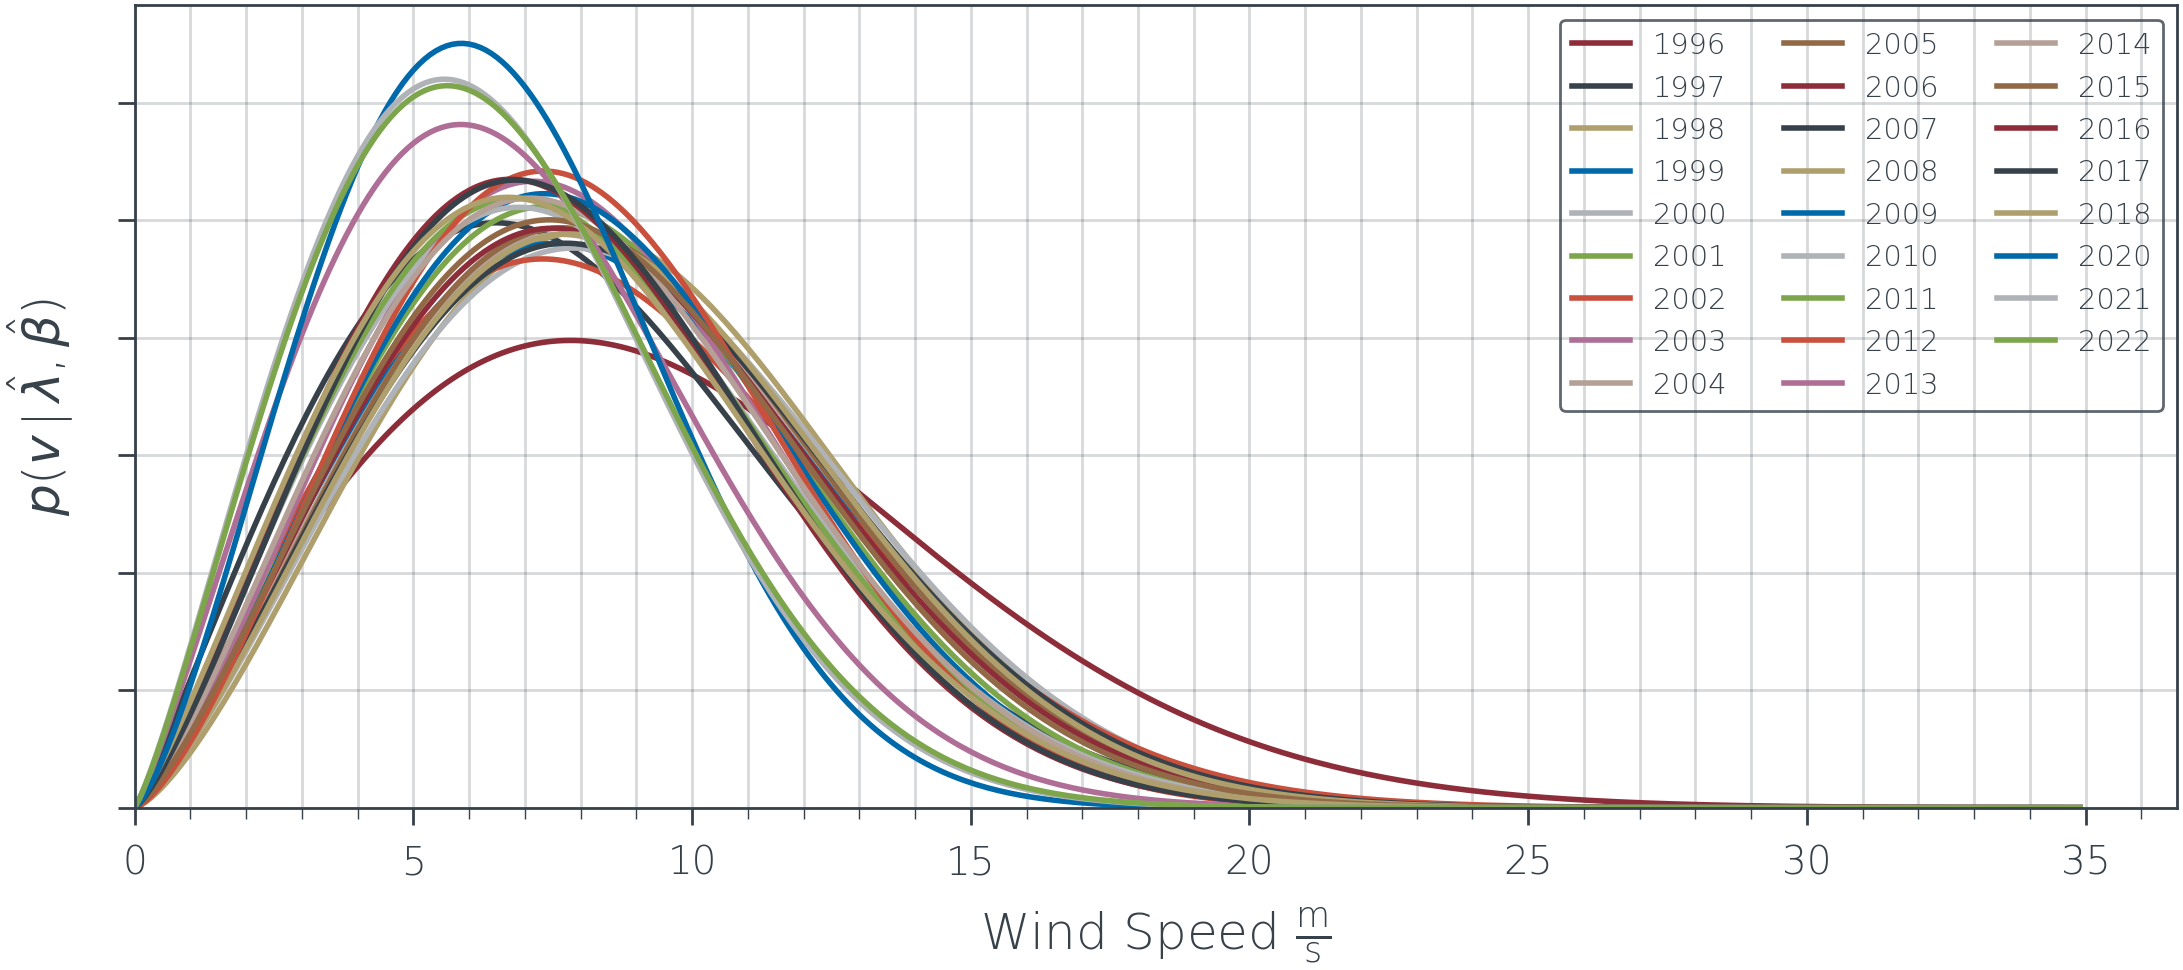

In [97]:
fig, ax = plt.subplots(1, 1)

X = np.arange(0, 35, 0.1)
for year, year_df in wind_year_dists.groupby("year"):
    w = year_df["weibull"].values[0]
    plt.plot(X, w.pdf(X), label=year)

ax.grid(which="both")
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
ax.set_yticklabels([])
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(ncols=(2022 - 1996) / 8, fontsize="xx-small")
ax.set_xlabel(r"Wind Speed $\frac{\text{m}}{\text{s}}$")
ax.set_ylabel(r"$p(v \mid \hat{\lambda}, \hat{\beta})$")

In [98]:
wind_month_pdfs = []
for (year, month), year_month_df in wind_df.groupby(["year", "month"]):
    X = year_month_df["FF_10_wind"].dropna().copy()
    weibull = Weibull.estimate(X)
    wind_month_pdfs.append([year, month, weibull, X])
wind_month_pdfs = pd.DataFrame(wind_month_pdfs, columns=["year", "month", "weibull", "wind"])
wind_month_pdfs
        

year  month                                            weibull  \
0    1996     12   Weibull distr for lambda=10.901997394939055, ...   
1    1997      1   Weibull distr for lambda=7.957978441723365, b...   
2    1997      2   Weibull distr for lambda=12.056819405208966, ...   
3    1997      3   Weibull distr for lambda=8.983493404318594, b...   
4    1997      4   Weibull distr for lambda=9.45360763877412, be...   
..    ...    ...                                                ...   
296  2022      8   Weibull distr for lambda=5.286573366235021, b...   
297  2022      9   Weibull distr for lambda=7.501257710648738, b...   
298  2022     10   Weibull distr for lambda=7.651447270742967, b...   
299  2022     11   Weibull distr for lambda=9.775116693614795, b...   
300  2022     12   Weibull distr for lambda=8.137357974083713, b...   

                                                  wind  
0    0       15.8
1       16.2
2       16.6
3      ...  
1    1559    7.9
1560    8.7
1561    8.8
1562    8....  
2    5428    3.2
5429    3.1
5430    3.0
5431    2....  
3    8922     8.2
8923     8.5
8924     8.3
8925   ...  
4    12772    7.2
12773    6.8
12774    6.8
12775  ...  
..                                                 ...  
296  132715    6.2
132716    6.4
132717    6.1
1327...  
297  137179     7.7
137180     7.2
137181     7.2
1...  
298  141499    12.2
141500    12.8
141501    11.7
1...  
299  145963    10.3
145964    10.2
145965     9.7
1...  
300  150283     5.6
150284     5.7
150285     5.6
1...  

[301 rows x 4 columns]

In [99]:
# https://en.wikipedia.org/wiki/Density_of_air#Dry_air
air_rho = 1.2250
# 120 meter diameter of wind turbine
sweep_area = math.pi * (70 / 2) ** 2

def expected_density(p: Weibull, A=sweep_area, rho=air_rho):
    # E[1/2 * rho * v^3] = 1/2 * rho * E[v^3] = 1/2 * rho * lambda^3 * G(1 + 3 / beta)
    # 1/2 * rho * v^3: 1/2 * kg/m^3 * m^3 / s^3 = W/m^2
    return 1/2 * rho * p.n_raw_moment(n=3)

C:\Users\gwend\AppData\Local\Temp\ipykernel_19340\657501253.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


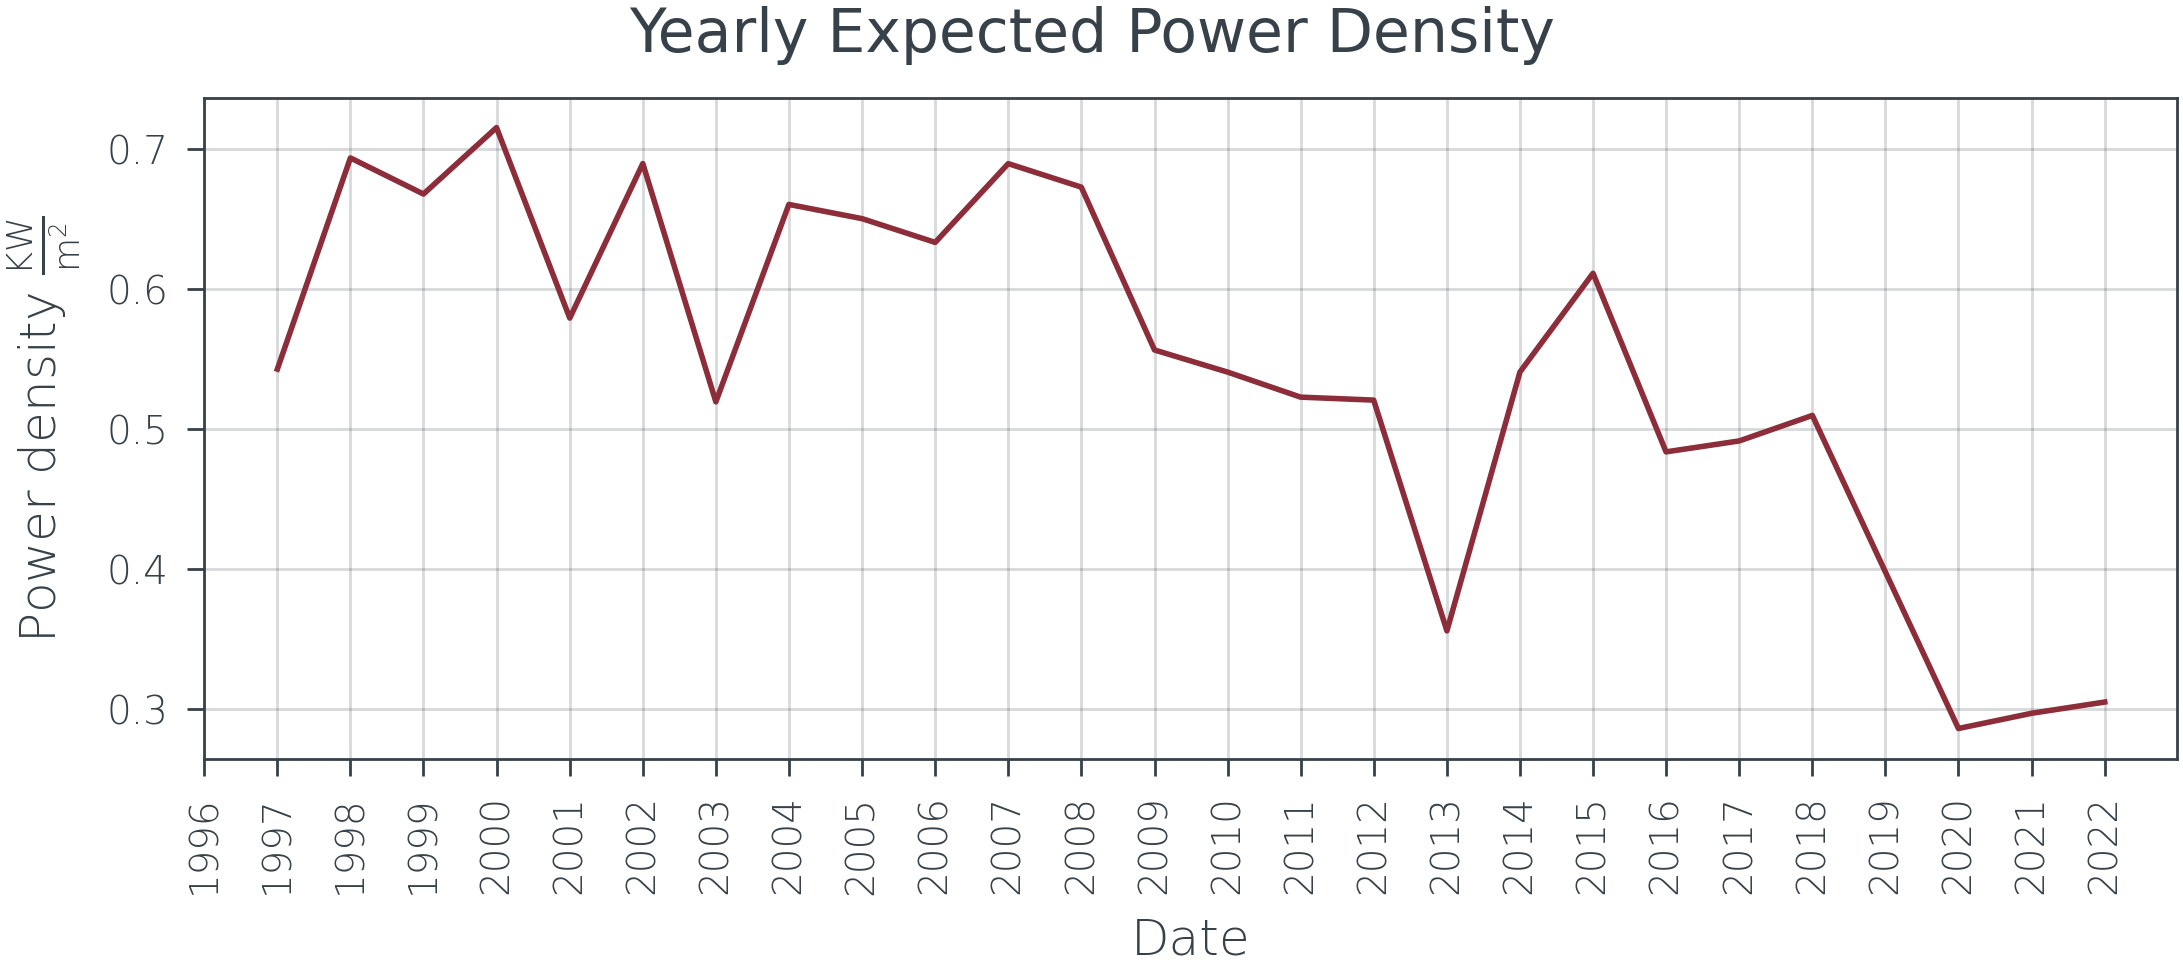

In [100]:
# plot expected values for each year
fig, ax = plt.subplots()
vals = []
for year, year_df in wind_year_dists.groupby("year"):
    if year < 1997: continue
    vals.append((year, 1e-3 * expected_density(year_df.weibull.values[0])))
years = list(map(lambda t: dt.datetime(t[0], 1, 1), vals))
e = list(map(lambda t: t[1], vals))
ax.plot(years, e)
ax.xaxis.set_major_locator(mdt.YearLocator())
ax.xaxis.set_major_formatter(mdt.DateFormatter("%Y"))
ax.tick_params(axis='x', which="major", rotation=90)
ax.set_xlabel("Date")
ax.set_xlim((dt.datetime(1996, 1, 1), dt.datetime(2022, 12, 30)))
ax.set_ylabel(r"Power density $\frac{\text{KW}}{\text{m}^2}$")
ax.grid()
fig.suptitle("Yearly Expected Power Density")
fig.show()

Text(0.5, 0.98, 'Monthly Expected Power Density')

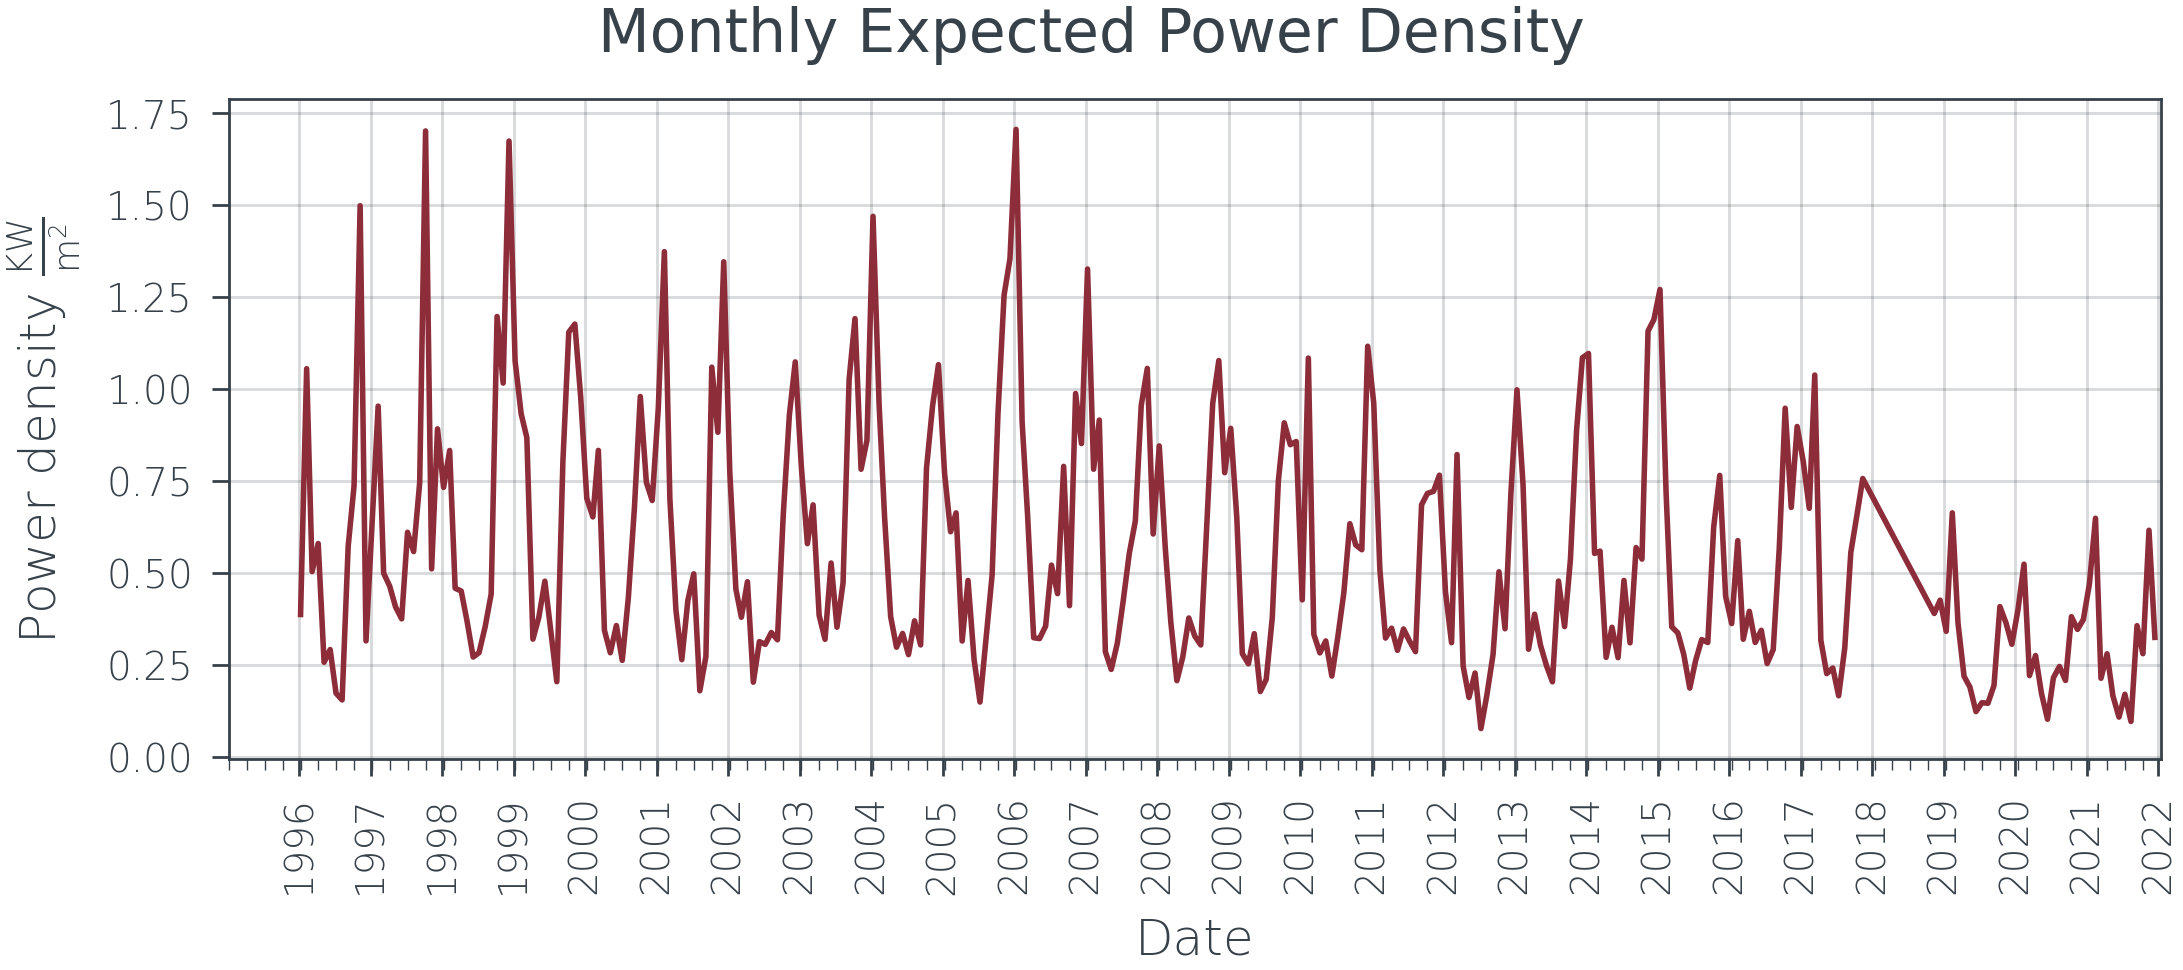

In [101]:
# plot expected values for each month
fig, ax = plt.subplots(1, 1)
vals = []
for (year, month), year_month_df in wind_month_pdfs.groupby(["year", "month"]):
    if year < 1997: continue
    vals.append((year, month, 1e-3 * expected_density(year_month_df.weibull.values[0])))
    # vals.append((year, month, year_month_df.pdf.values[0].mean))
months = list(map(lambda t: dt.datetime(t[0], t[1], 1), vals))
e = list(map(lambda t: t[2], vals))
ax.plot(months, e)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(365))
ax.xaxis.set_major_formatter(mdt.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdt.MonthLocator(interval=3))
# ax.xaxis.set_minor_formatter(mdt.DateFormatter("%b"))
ax.tick_params(axis='x', which='minor', rotation=45, labelsize=3)
ax.tick_params(axis='x', which="major", rotation=90)
ax.set_xlabel("Date")
ax.set_xlim((dt.datetime(1996, 1, 1), dt.datetime(2022, 12, 30)))
ax.set_ylabel(r"Power density $\frac{\text{KW}}{\text{m}^2}$")
ax.grid()
fig.suptitle("Monthly Expected Power Density")

In [102]:
start_y = 1999
start_dt = dt.datetime(start_y, 1, 1)
end_y = 2022
step_size = 1
extrapol_days = 365 * 8

X = np.array(list(map(lambda d: (d - start_dt).days, months))).reshape(-1, 1)
Y = np.array(e)
r = range(start_y - 1997, 365 * (end_y - start_y) + extrapol_days, step_size)
x = np.array(r).reshape(-1, 1)

k = 1e-6 * GPK.DotProduct(Y.mean()) + GPK.ExpSineSquared(length_scale=1, periodicity=180) + 1.5 * GPK.ExpSineSquared(length_scale=1, periodicity=365) + 0.5 * GPK.RBF(length_scale=30)
gp = GP(kernel=k, alpha=1e-2, optimizer=None)


Text(0.5, 0.98, 'Prior Samples')

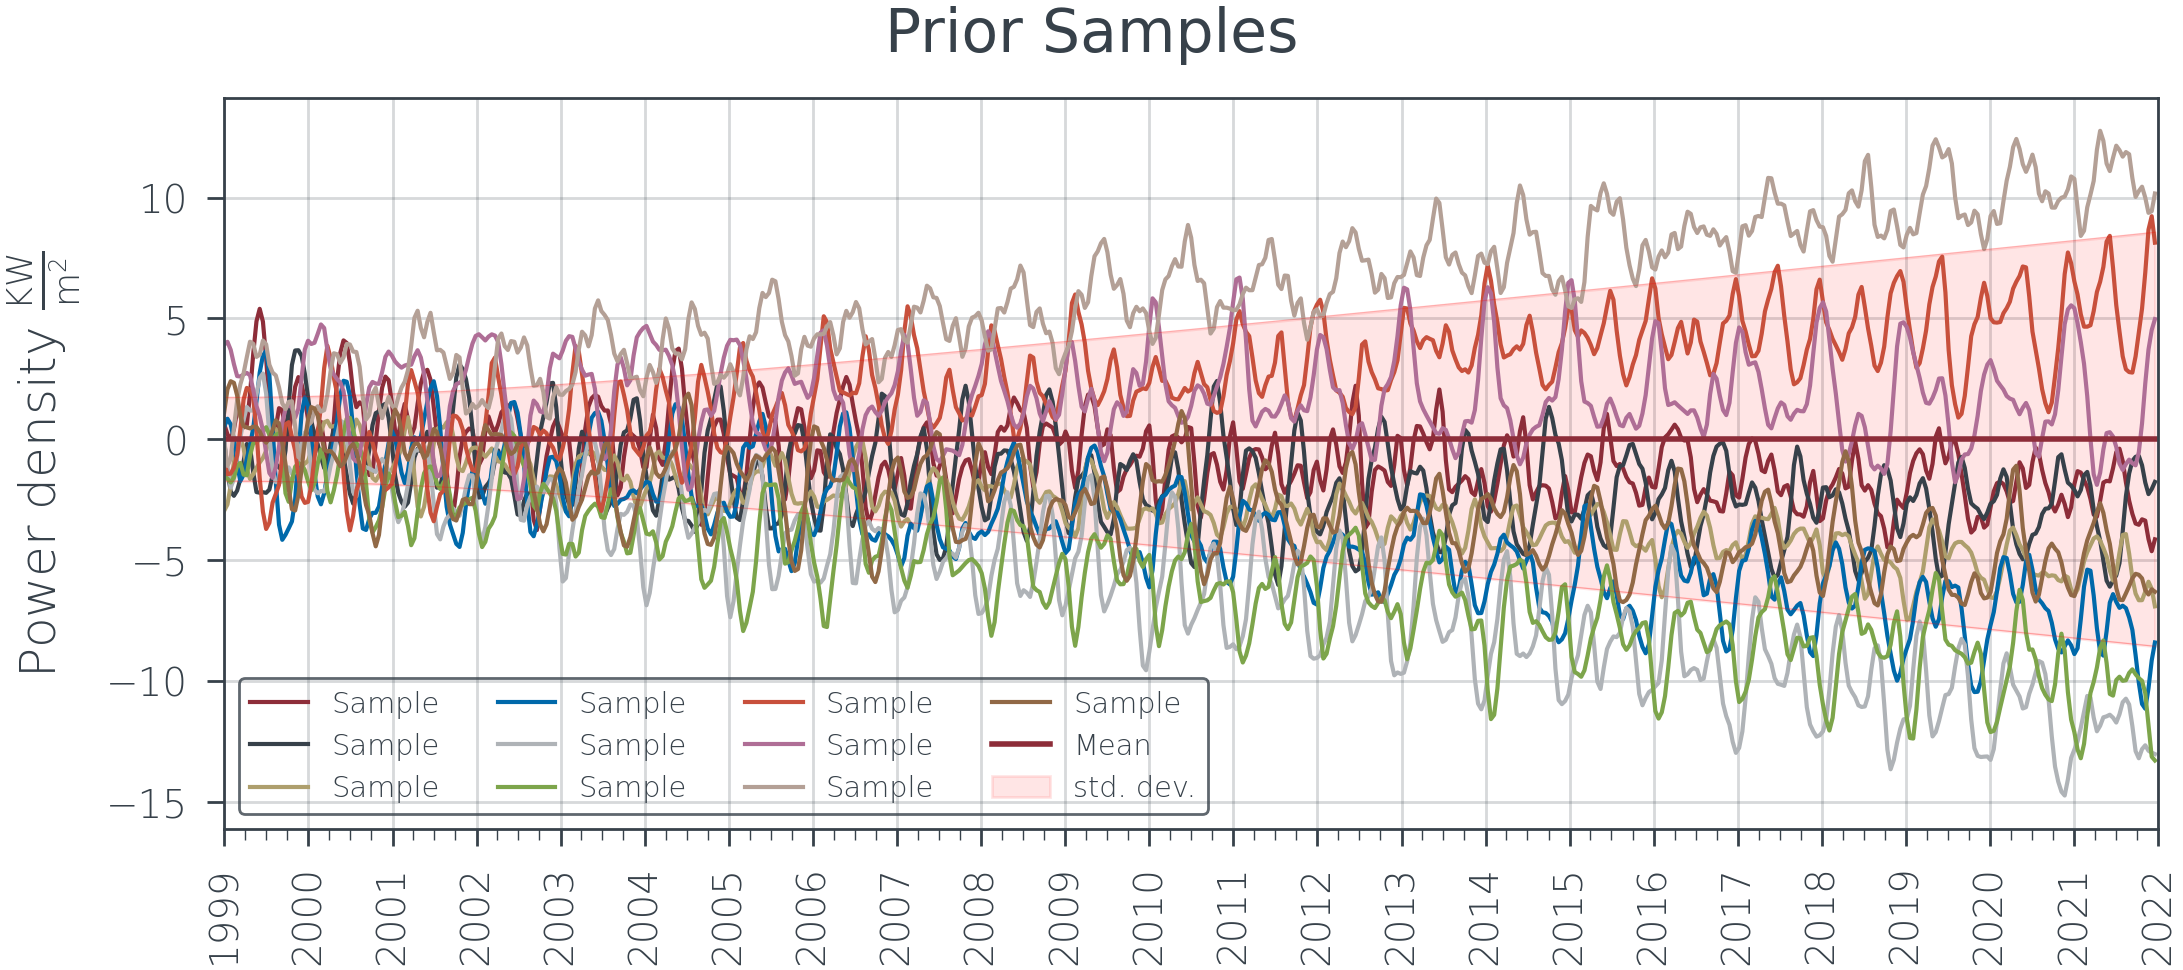

In [103]:
fig, ax = plt.subplots()

sample_steps = 14

x_sample = np.array(range(0, 365 * (end_y - start_y), sample_steps)).reshape(-1, 1)
pred_mean, pred_std = gp.predict(x_sample, return_std=True)
samples = gp.sample_y(x_sample, n_samples=10, random_state=25)
x_sample_dt = days_to_date(start_dt, x_sample)

ax.plot(x_sample_dt, samples, label="Sample", linewidth=0.75)
ax.plot(x_sample_dt, pred_mean, label="Mean")
ax.plot(x_sample_dt, pred_mean + pred_std, color="red", alpha=0.25, linewidth=0.2) 
ax.plot(x_sample_dt, pred_mean - pred_std, color="red", alpha=0.25, linewidth=0.2)
ax.fill_between(x_sample_dt, pred_mean + pred_std, pred_mean - pred_std, alpha=0.1, color="red", label="std. dev.")
ax.legend(ncols=4, fontsize="xx-small")
ax.set_xlim(dt.datetime(start_y, 1, 1), dt.datetime(end_y, 1, 1))
ax.xaxis.set_minor_locator(mdt.MonthLocator(interval=3))
ax.xaxis.set_major_locator(mdt.YearLocator(base=1))
ax.tick_params(axis='x', which="major", rotation=90)
ax.grid()
ax.set_ylabel(r"Power density $\frac{\text{KW}}{\text{m}^2}$")
fig.suptitle("Prior Samples")

C:\Users\gwend\AppData\Local\Temp\ipykernel_19340\3374618092.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


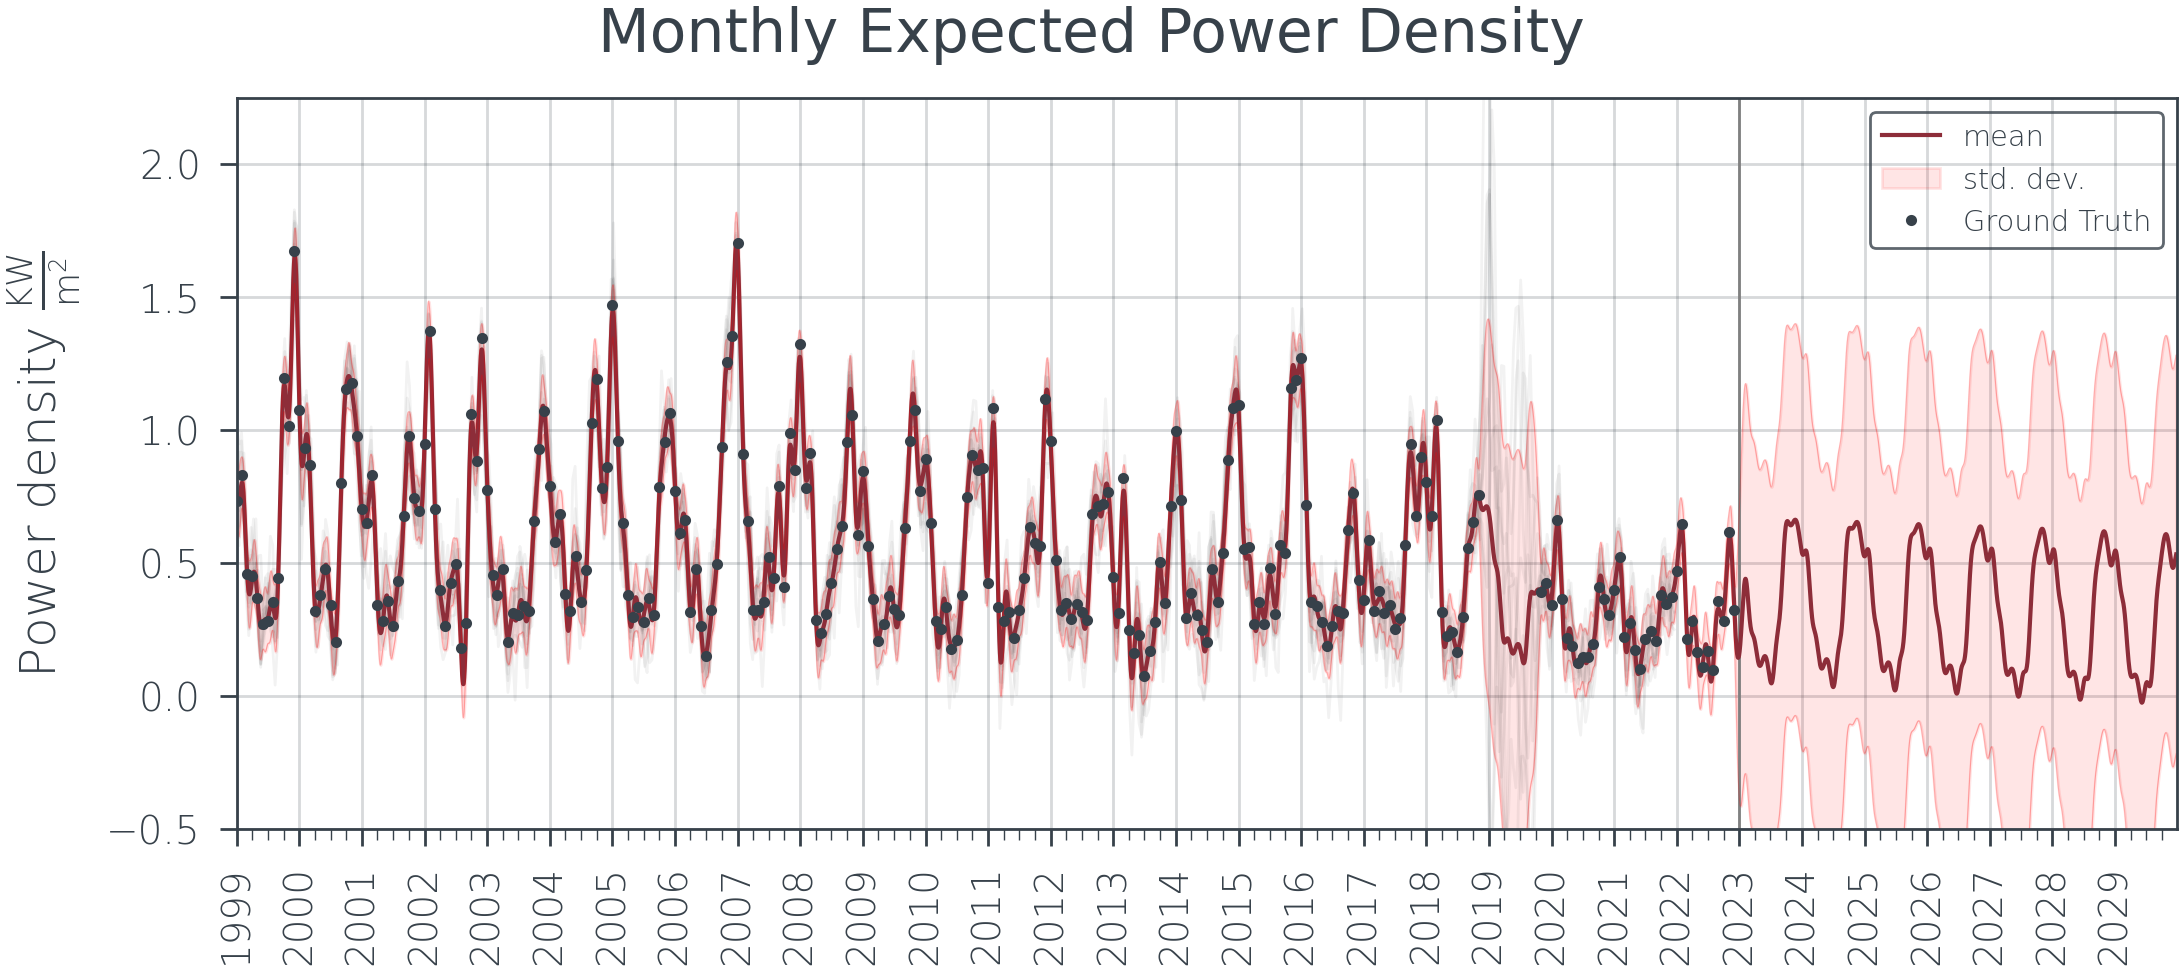

In [104]:
gp.fit(X, Y)
pred_mean, std = gp.predict(x, return_std=True)
samples = gp.sample_y(x_sample, n_samples=10)
x_dt = days_to_date(start_dt, x)

fig, ax = plt.subplots()
ax.axvline(dt.datetime(2023, 1, 1), color="gray", linewidth=0.5)
ax.plot(x_sample_dt, samples, alpha=0.05, color="black", linewidth=0.5)
ax.plot(x_dt, pred_mean, "-", linewidth=0.75, label="mean")
ax.plot(x_dt, pred_mean + std, "-", alpha=0.25, color="red", linewidth=0.2)
ax.plot(x_dt, pred_mean - std, "-", alpha=0.25, color="red", linewidth=0.2)
ax.fill_between(x_dt, pred_mean + std, pred_mean - std, color="red", alpha=0.1, label="std. dev.")

X_dt = days_to_date(start_dt, X)
ax.plot(X_dt, Y, ".", markersize=2, label="Ground Truth")

ax.set_xlim(dt.datetime(start_y, 1, 1), dt.datetime(end_y, 1, 1) + dt.timedelta(extrapol_days))
ax.set_ylim(-0.5, 2.25)
ax.set_ylabel(r"Power density $\frac{\text{KW}}{\text{m}^2}$")
# ax.set_xlabel("Date")
ax.xaxis.set_minor_locator(mdt.MonthLocator(interval=3))
ax.xaxis.set_major_locator(mdt.YearLocator(base=1))
ax.legend(fontsize="xx-small", ncols=1)
ax.tick_params(axis='x', which="major", rotation=90)
ax.grid()
fig.suptitle("Monthly Expected Power Density")
fig.show()

# Test the new utils out


In [105]:
from get_params import yearly_params
from get_params import monthly_params

yearly_df=yearly_params(1997, 2022, df)
monthly_df=monthly_params(1997, 2022, df)

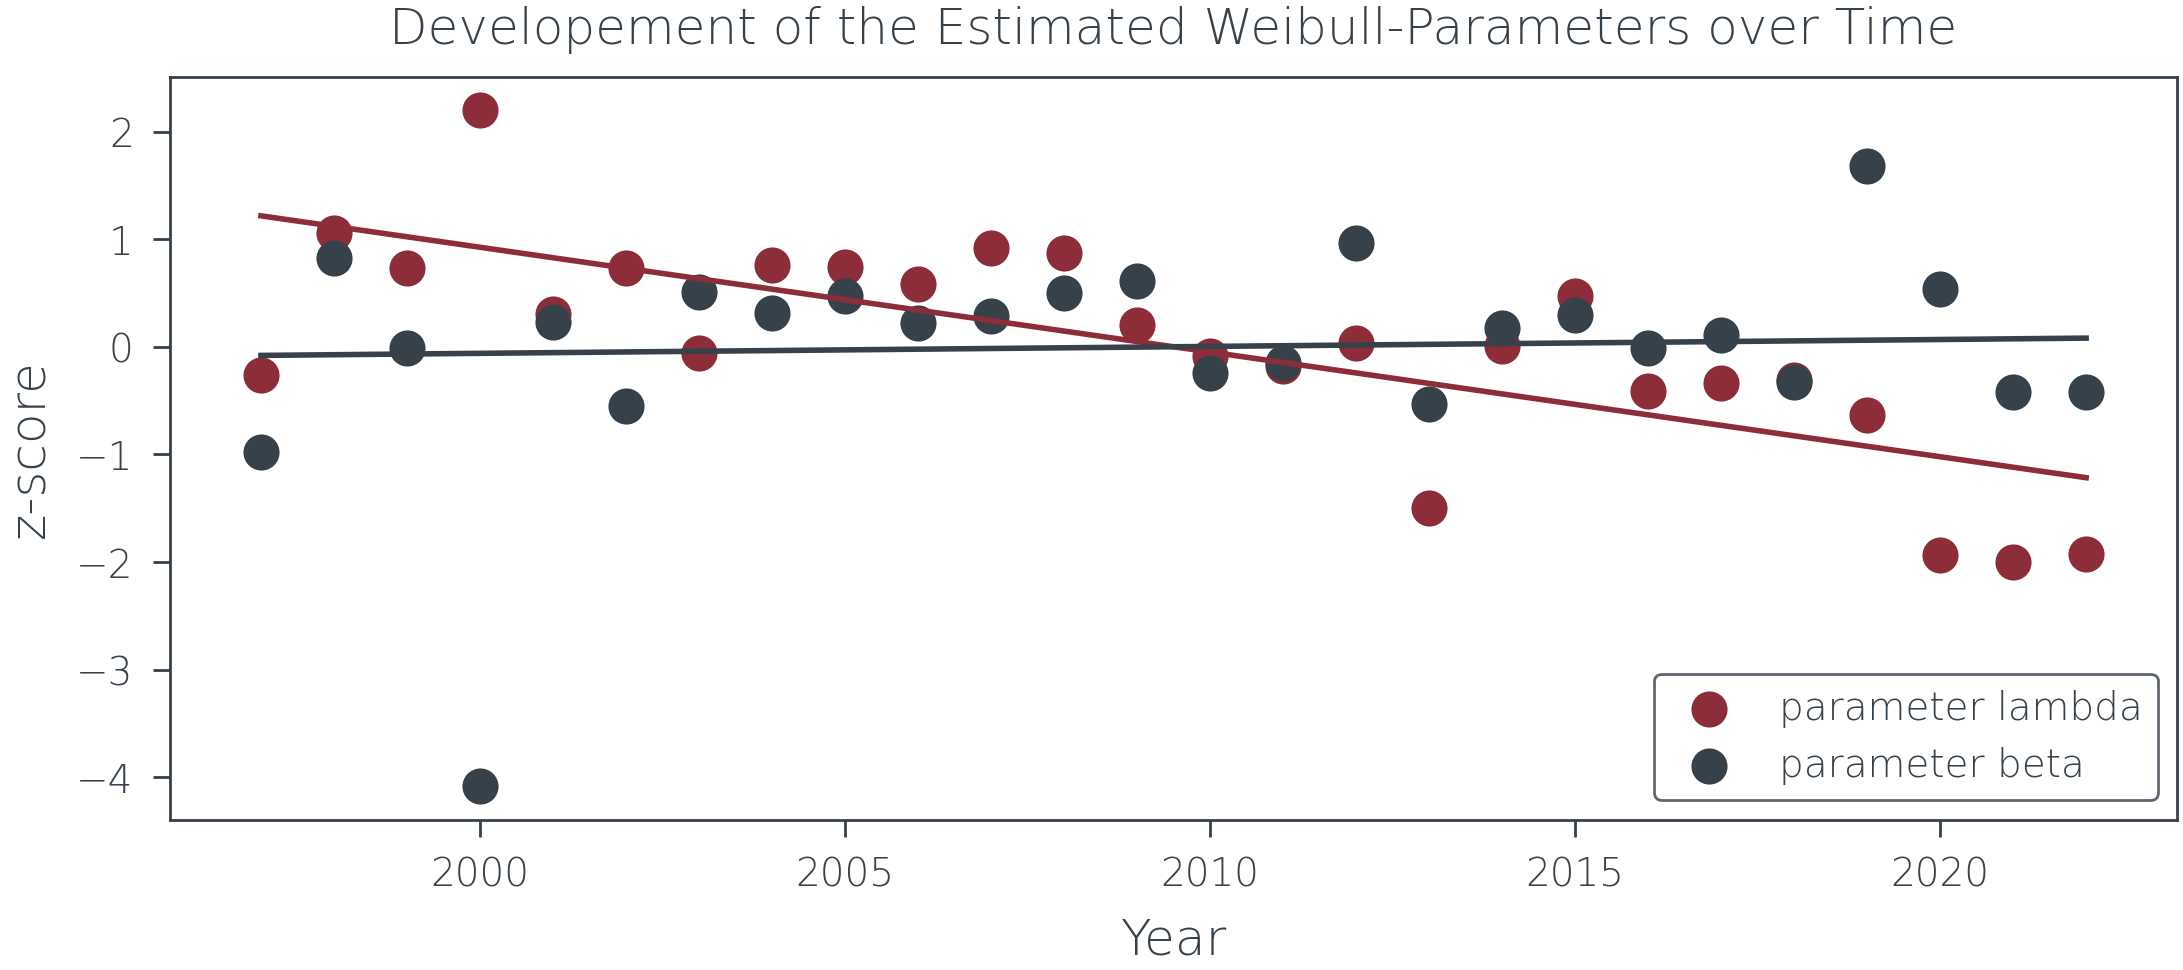

In [106]:

plt.scatter(yearly_df.index, (yearly_df['param_lambda'] -yearly_df['param_lambda'].mean())/yearly_df['param_lambda'].std(), label='parameter lambda' )
plt.scatter(yearly_df.index, (yearly_df['param_beta'] -yearly_df['param_beta'].mean())/yearly_df['param_beta'].std(), label='parameter beta' )

l_pol=np.polyfit(yearly_df.index,(yearly_df['param_lambda'] -yearly_df['param_lambda'].mean())/yearly_df['param_lambda'].std(), 1)
l_model = np.poly1d(l_pol)
plt.plot(yearly_df.index,l_model(yearly_df.index))

b_pol=np.polyfit(yearly_df.index,(yearly_df['param_beta'] -yearly_df['param_beta'].mean())/yearly_df['param_lambda'].std(), 1)
b_model = np.poly1d(b_pol)
plt.plot(yearly_df.index,b_model(yearly_df.index))

plt.title('Developement of the Estimated Weibull-Parameters over Time')
plt.xlabel('Year')
plt.ylabel('z-score')
plt.legend()
plt.show()

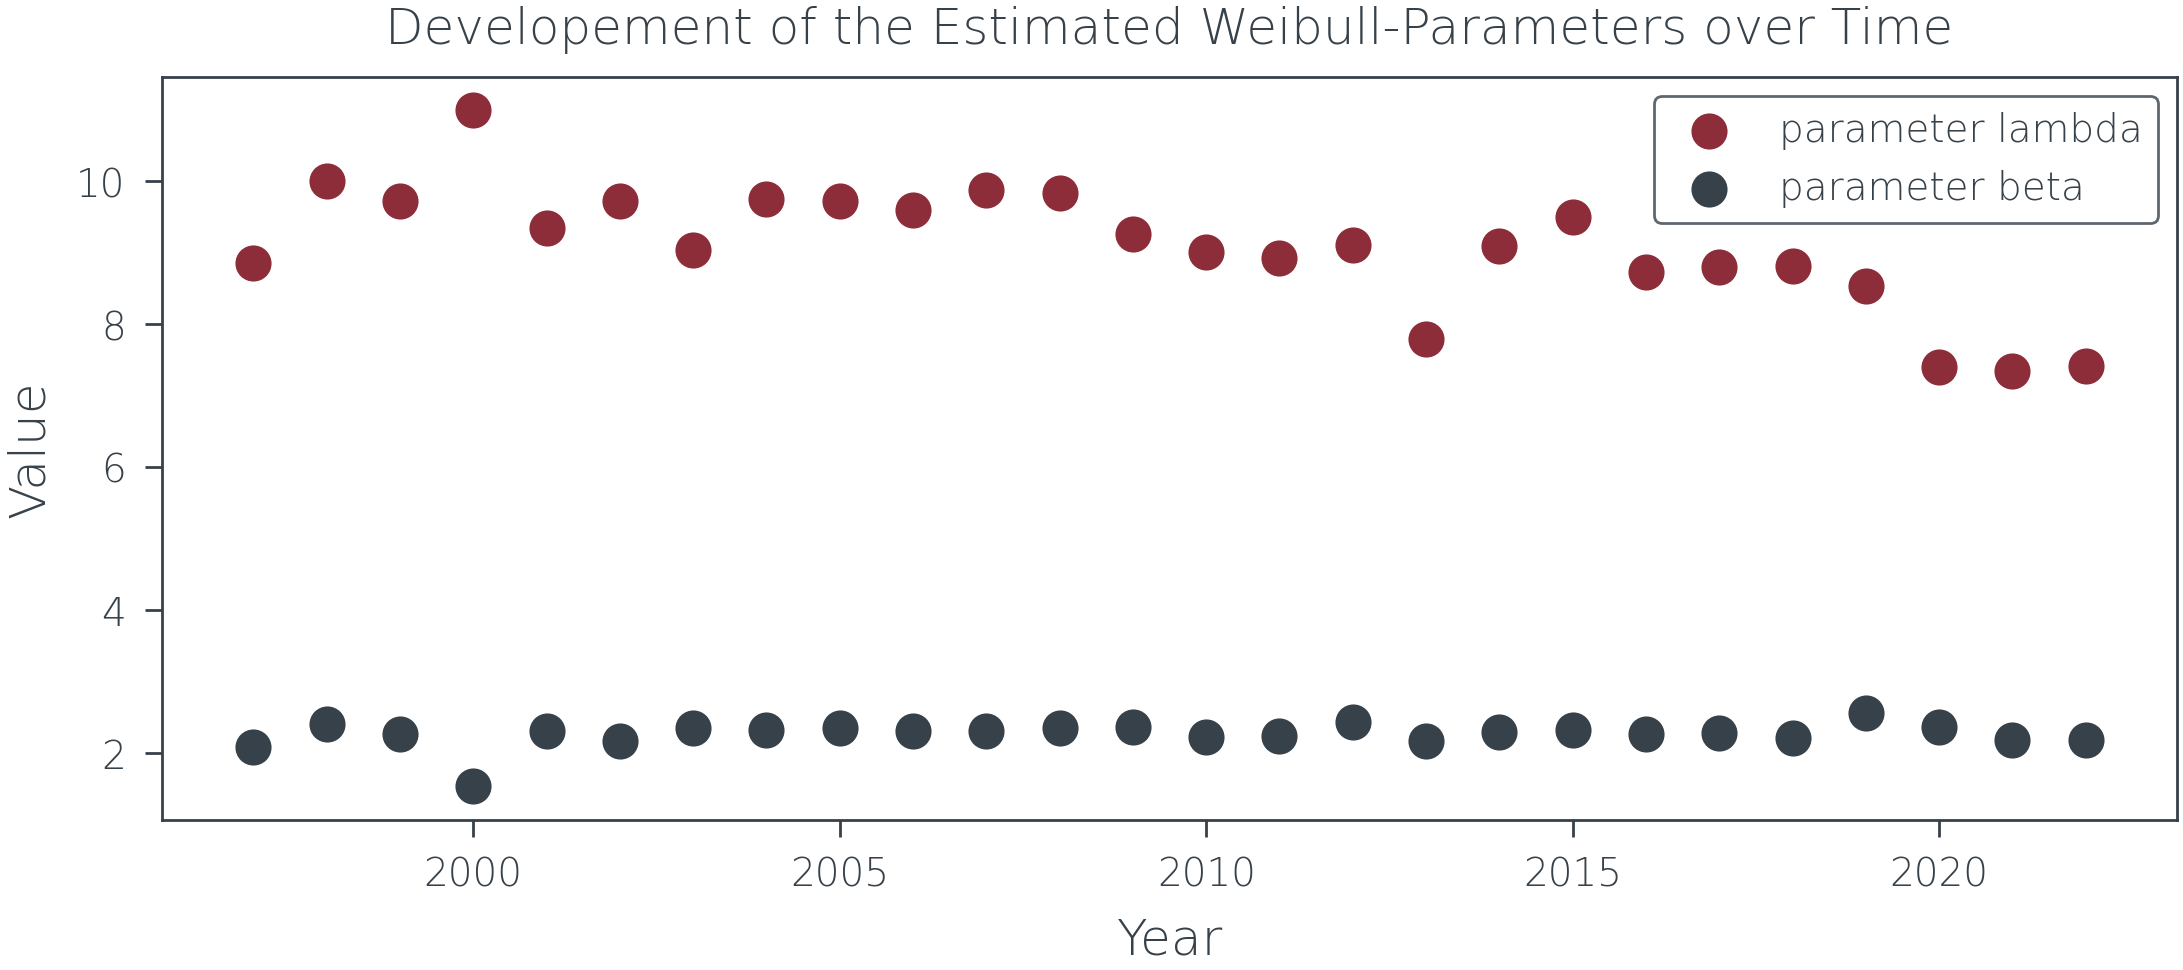

In [107]:
plt.scatter(yearly_df.index, yearly_df['param_lambda'], label='parameter lambda' )
plt.scatter(yearly_df.index, yearly_df['param_beta'], label='parameter beta' )

plt.title('Developement of the Estimated Weibull-Parameters over Time')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

c:\Users\gwend\Uni\WiSe23\DataLiteracy\DataLiteracyProject\notes\../util\weibull.py:250: RuntimeWarning: divide by zero encountered in scalar divide
  kl=kl+empiric_pdf[i]*np.log(empiric_pdf[i]/ (self.cdf(edges[i+1]) -self.cdf(edges[i])) +0.001)
c:\Users\gwend\Uni\WiSe23\DataLiteracy\DataLiteracyProject\notes\../util\weibull.py:250: RuntimeWarning: invalid value encountered in scalar divide
  kl=kl+empiric_pdf[i]*np.log(empiric_pdf[i]/ (self.cdf(edges[i+1]) -self.cdf(edges[i])) +0.001)


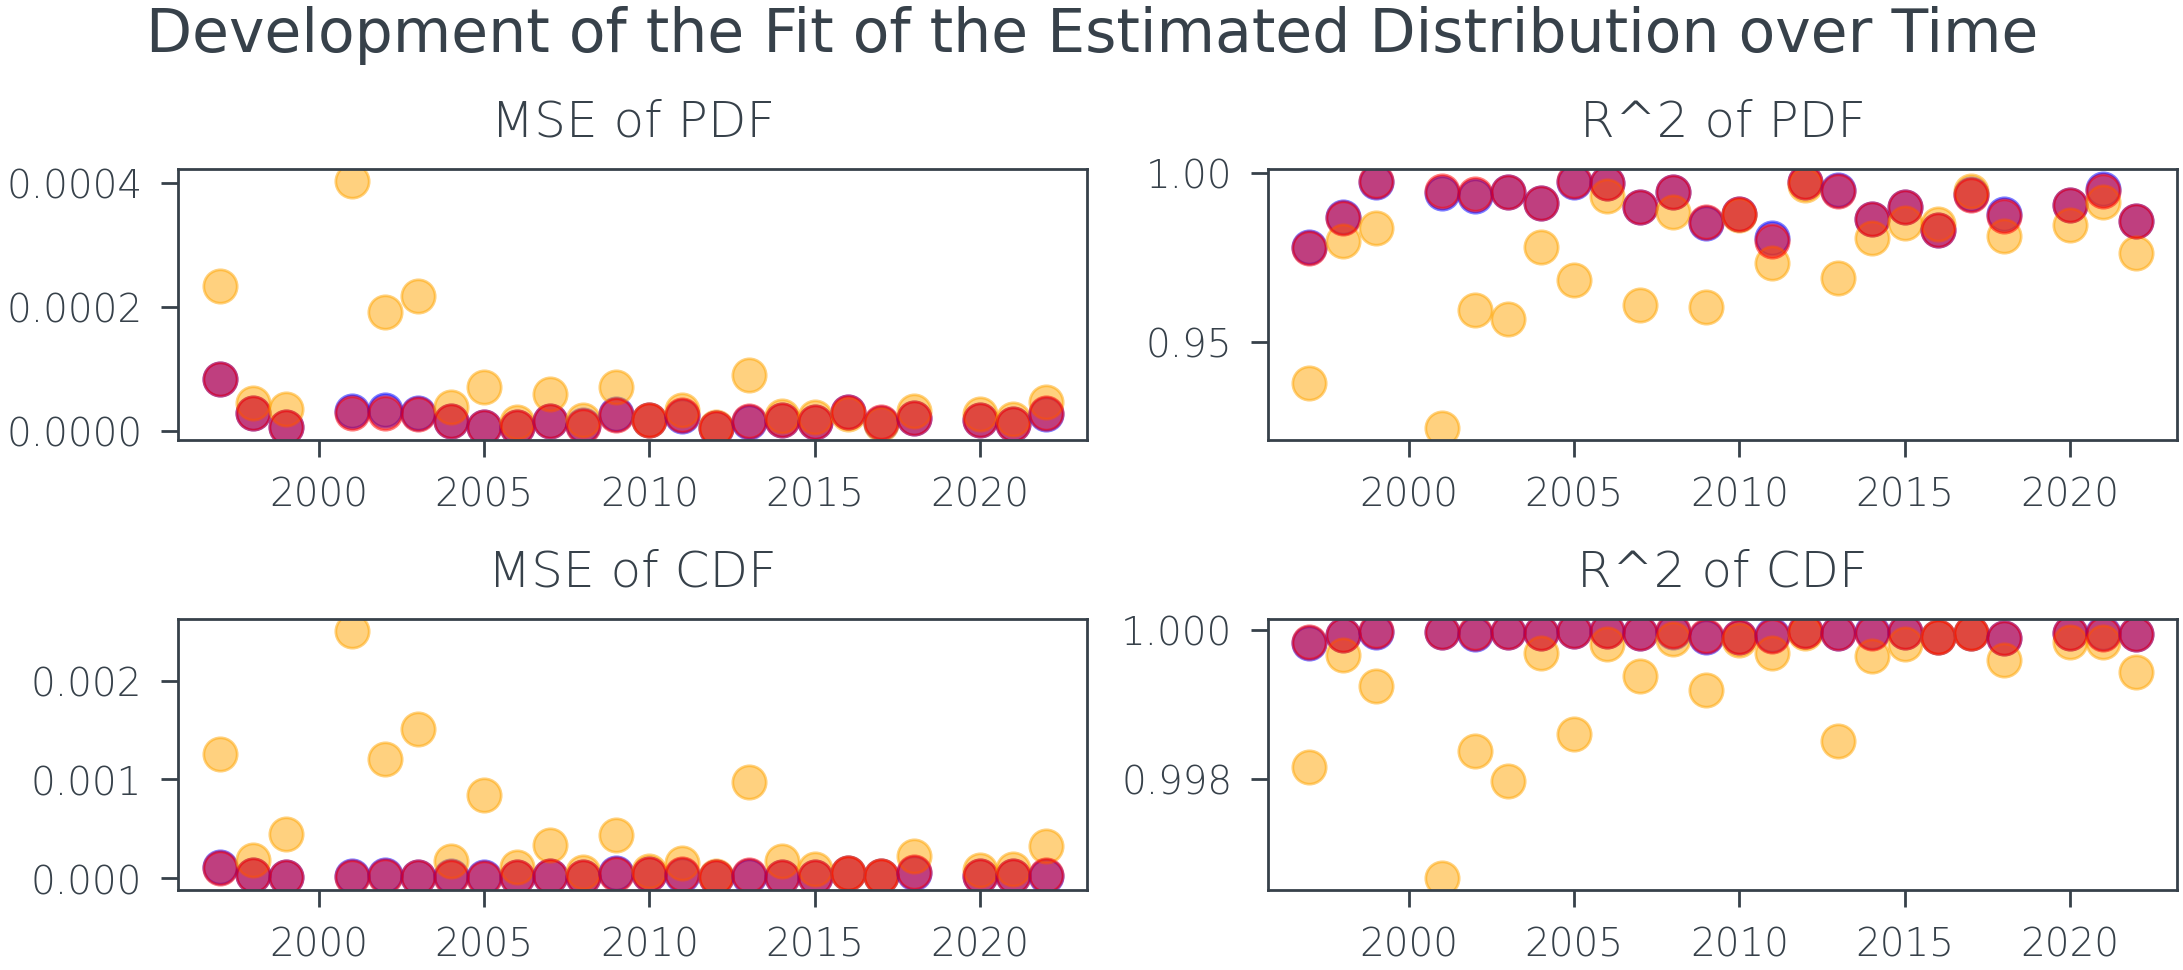

In [108]:
# how does the goodness of fit develop over time (yearly)?

figure, axis = plt.subplots(2, 2)

for y in range(1997, 2023):
    if y==2000 or y==2019:
        continue
    mle_weibull=Weibull.estimate(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    graphical_weibull=Weibull.graphical_estimate(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    epf_weibull=Weibull.epf_estimate(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    
    fit1= mle_weibull.fit(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    fit2=graphical_weibull.fit(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    fit3=epf_weibull.fit(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])


    axis[0,0].scatter(y,fit1[0], color='blue', alpha=0.5 , label='MLM') 
    axis[0,0].scatter(y, fit2[0], color='orange', alpha=0.5, label='graphical method')
    axis[0,0].scatter(y, fit3[0], color='red', alpha=0.5, label='epf method')
    axis[0, 0].set_title("MSE of PDF")

    axis[1,0].scatter(y, fit1[1], color='blue', alpha=0.5) 
    axis[1,0].scatter(y, fit2[1], color='orange', alpha=0.5)
    axis[1,0].scatter(y, fit3[1], color='red', alpha=0.5)
    axis[1, 0].set_title("MSE of CDF")

    axis[0,1].scatter(y, fit1[2], color='blue', alpha=0.5) 
    axis[0,1].scatter(y, fit2[2], color='orange', alpha=0.5)
    axis[0,1].scatter(y, fit3[2], color='red', alpha=0.5)
    axis[0, 1].set_title("R^2 of PDF")

    axis[1,1].scatter(y, fit1[3], color='blue', alpha=0.5) 
    axis[1,1].scatter(y, fit2[3], color='orange', alpha=0.5)
    axis[1,1].scatter(y, fit3[3], color='red', alpha=0.5)
    axis[1, 1].set_title("R^2 of CDF")

figure.suptitle('Development of the Fit of the Estimated Distribution over Time')
#plt.xlabel('Year')
#plt.ylabel('Fit')
#plt.legend()
plt.show()

In [109]:
'''
from get_params import bf_classifier

from matplotlib.colors import to_hex
class_colors = plt.cm.turbo(np.linspace(0,1,11))
class_colors= [to_hex(color) for color in class_colors]

# Vectorize the scalar function to make it work on arrays
bf_classifier_vectorized = np.vectorize(bf_classifier)
                                        
for n in range(0,11):
    yearly_df[f'Raw_Class_{n}']=0
for y in yearly_df.index:
    for n in range(0,11):
        yearly_df.loc[y, f'Raw_Class_{n}']=len(df[(df['MESS_DATUM'].dt.year==y) &(bf_classifier_vectorized(df['FF_10_wind'])==n)])



# Make a stackplot:
my_raw_labels=[] 
for n in range(0,11):
    my_raw_labels=np.append(my_raw_labels, f'Raw_Class_{n}')
print(class_colors)
plt.stackplot(yearly_df.index,[yearly_df[f'Raw_Class_0'], yearly_df[f'Raw_Class_1'], yearly_df[f'Raw_Class_2'], yearly_df[f'Raw_Class_3'], yearly_df[f'Raw_Class_4'],
              yearly_df[f'Raw_Class_5'],yearly_df[f'Raw_Class_6'],yearly_df[f'Raw_Class_7'],yearly_df[f'Raw_Class_8'],yearly_df[f'Raw_Class_9'], yearly_df[f'Raw_Class_10']], 
              colors=class_colors, labels=my_raw_labels)
plt.legend(loc='best', fontsize=5)

plt.title('Development of the Raw Occurences of Winds corresponding to the Beaufort Classes')
plt.ylabel('Number of Measurements')
plt.xlabel('Year')
plt.show()

'''

"\nfrom get_params import bf_classifier\n\nfrom matplotlib.colors import to_hex\nclass_colors = plt.cm.turbo(np.linspace(0,1,11))\nclass_colors= [to_hex(color) for color in class_colors]\n\n# Vectorize the scalar function to make it work on arrays\nbf_classifier_vectorized = np.vectorize(bf_classifier)\n                                        \nfor n in range(0,11):\n    yearly_df[f'Raw_Class_{n}']=0\nfor y in yearly_df.index:\n    for n in range(0,11):\n        yearly_df.loc[y, f'Raw_Class_{n}']=len(df[(df['MESS_DATUM'].dt.year==y) &(bf_classifier_vectorized(df['FF_10_wind'])==n)])\n\n\n\n# Make a stackplot:\nmy_raw_labels=[] \nfor n in range(0,11):\n    my_raw_labels=np.append(my_raw_labels, f'Raw_Class_{n}')\nprint(class_colors)\nplt.stackplot(yearly_df.index,[yearly_df[f'Raw_Class_0'], yearly_df[f'Raw_Class_1'], yearly_df[f'Raw_Class_2'], yearly_df[f'Raw_Class_3'], yearly_df[f'Raw_Class_4'],\n              yearly_df[f'Raw_Class_5'],yearly_df[f'Raw_Class_6'],yearly_df[f'Raw_Class_7'

In [110]:
# contains the daily average windspeed starting in the 1950s
early_df = pd.read_csv(
    "FG_STAID000468.csv",
    skiprows=19,
    sep=",",
    index_col=None,
    skipfooter=0,
    engine="python",
)
# convert the date and divide the windspeed by 10, so it's given in m/s
early_df['DATE']=pd.to_datetime(early_df["DATE"], format="%Y%m%d")
early_df['FG']=early_df['FG']/10


#compute the yearly mean

mean_df=pd.DataFrame(index=np.arange(1959, 2024), columns=['Mean']) 
F=early_df[early_df['FG']>0]
for y in mean_df.index:
    mean_df.loc[y, 'Mean']=F[F['DATE'].dt.year==y]['FG'].mean()

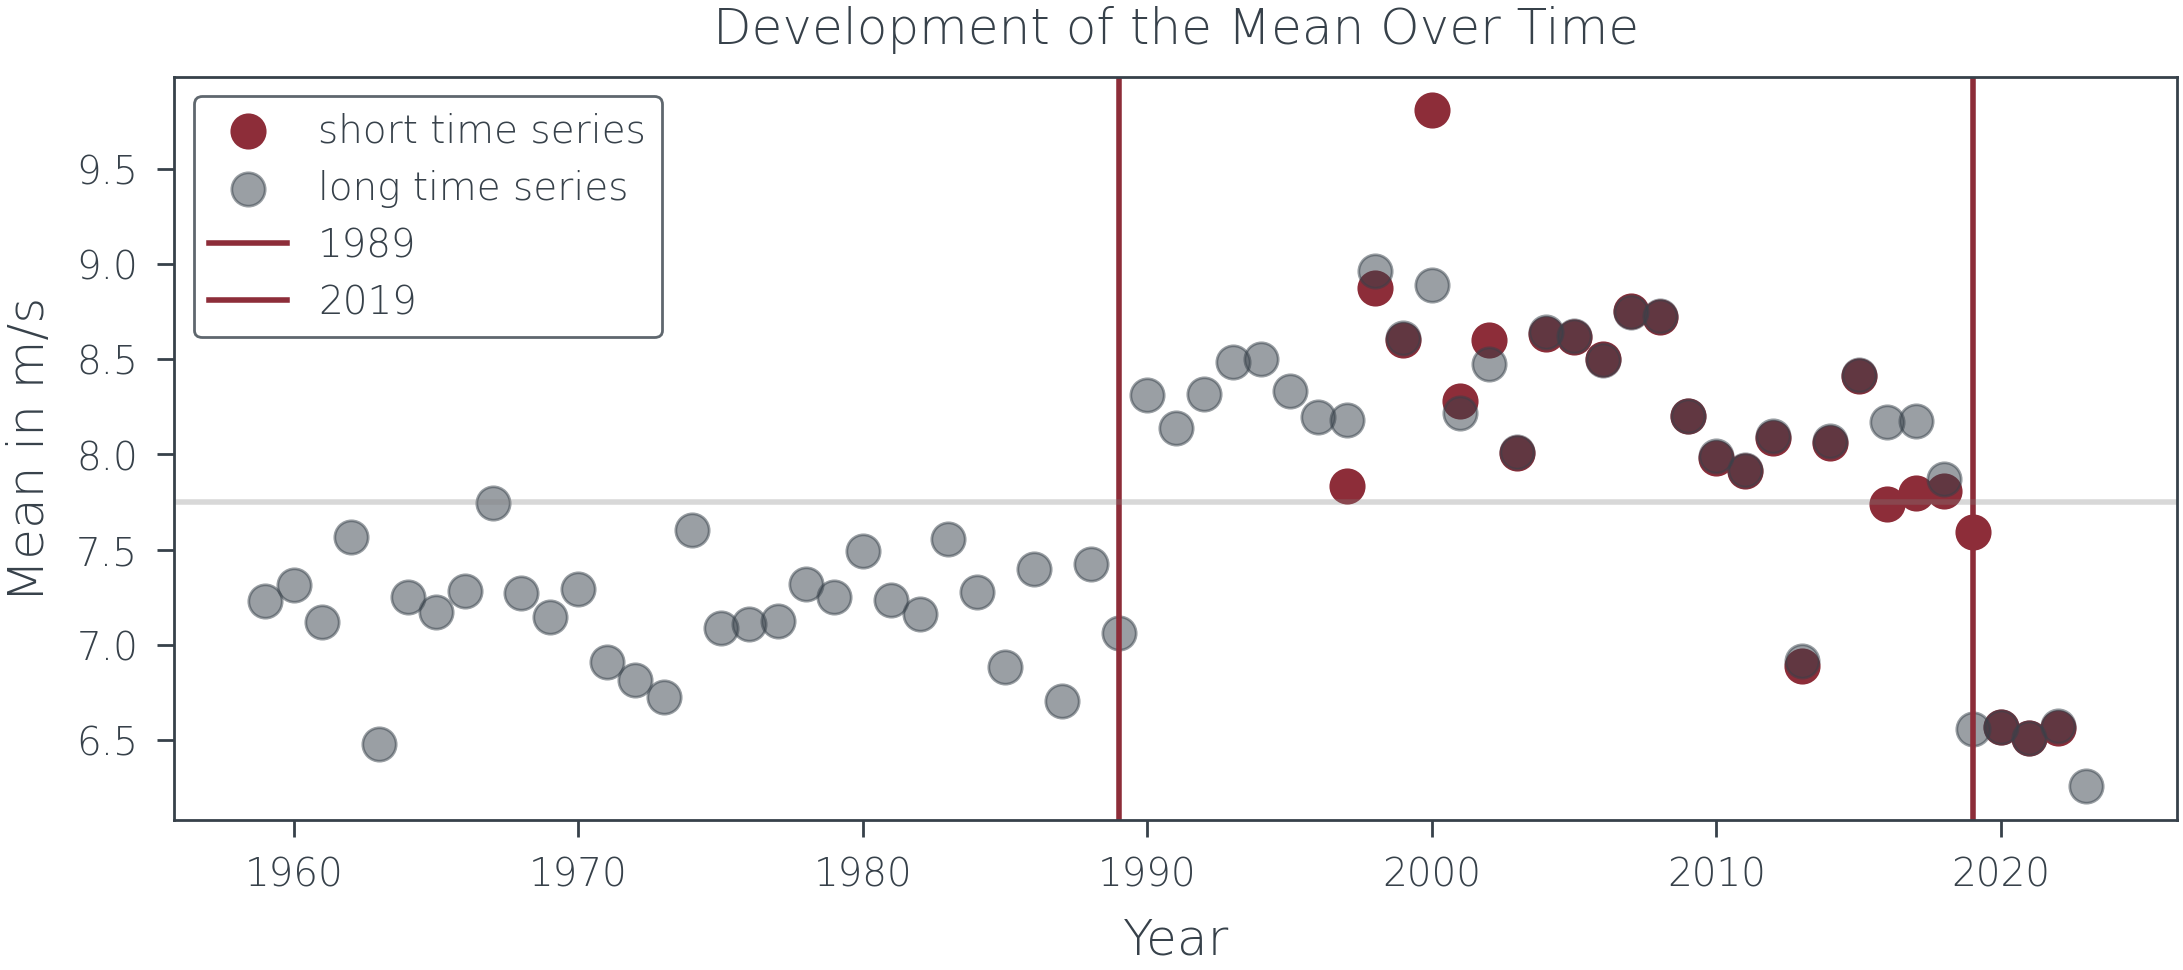

In [121]:

import scipy

# plot the mean per year

X=df['FF_10_wind']
X=df[ (df['FF_10_wind']>0) & ~np.isnan(df['FF_10_wind'])]
yearly_df['Mean']=0.0
for y in yearly_df.index:
    yearly_df.loc[y, 'Mean']=X[X['MESS_DATUM'].dt.year==y]['FF_10_wind'].mean() 

plt.scatter(yearly_df.index,  yearly_df['Mean'] , label='short time series',alpha=1)
plt.scatter(mean_df.index, mean_df,  label='long time series', alpha=0.5)
plt.axvline(x=1989, label="1989")
plt.axvline(x=2019, label='2019')
plt.axhline(y=7.75, color='gray', alpha=0.3)
plt.title('Development of the Mean Over Time' )
plt.ylabel('Mean in m/s')
plt.xlabel('Year')
plt.legend()
plt.show()




In [112]:
early_df.set_index('DATE', inplace=True)
from datetime import datetime
early_df['FF']=-999
X=df['FF_10_wind']
X=df[ (df['FF_10_wind']>0) & ~np.isnan(df['FF_10_wind'])]
'''
for date in early_df.index:
    print(pd.to_datetime(date).strftime('%Y-%m-%d'))
    
    if y < 1997:
        continue
    Y= X[ (X['MESS_DATUM'].dt.date== date.date()) ]['FF_10_wind']
    if len(Y)>0:
       mean=Y.mean()
       print(mean)
       early_df.loc[str(date), 'FF']=mean

early_df

'''

"\nfor date in early_df.index:\n    print(pd.to_datetime(date).strftime('%Y-%m-%d'))\n    \n    if y < 1997:\n        continue\n    Y= X[ (X['MESS_DATUM'].dt.date== date.date()) ]['FF_10_wind']\n    if len(Y)>0:\n       mean=Y.mean()\n       print(mean)\n       early_df.loc[str(date), 'FF']=mean\n\nearly_df\n\n"

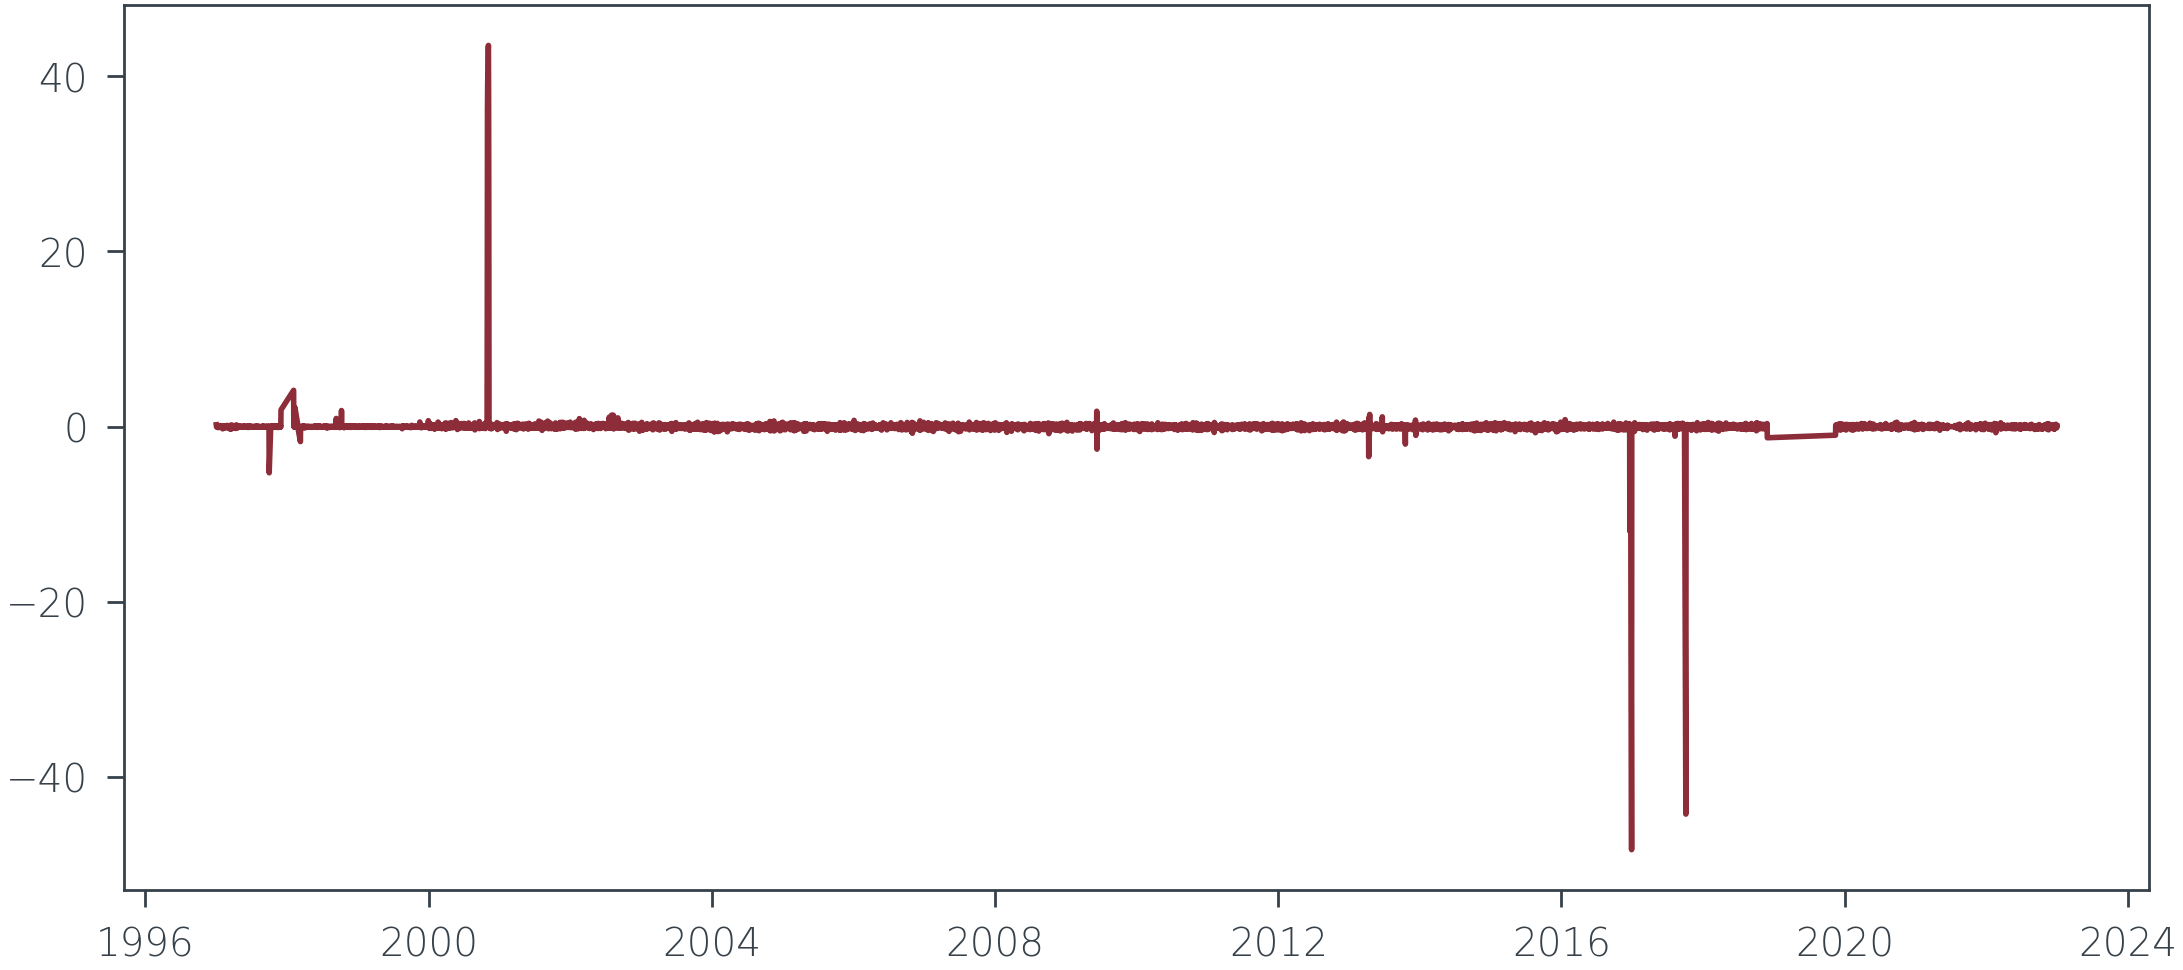

0.15729184623854128
106
0.011793502447708056


In [113]:

# Filter X based on the condition for all dates in early_df.index at once
filtered_X = X[(X['MESS_DATUM'].dt.year >= 1997) & X['MESS_DATUM'].dt.date.isin(early_df.index.date)]

# Calculate mean values for each date
mean_values = filtered_X.groupby(filtered_X['MESS_DATUM'].dt.date)['FF_10_wind'].mean()

# Update early_df with the calculated means
early_df['FF'] = early_df.index.date
early_df['FF'] = early_df['FF'].map(mean_values)
# Print early_df with means
mask=(~ np.isnan(early_df['FF'])) & (early_df['FG']>0) 
plt.plot(early_df[mask].index, early_df[mask]['FF'] -early_df[mask]['FG'] )
plt.show()
diff=early_df[mask]['FF'] -early_df[mask]['FG']
s=(diff[(diff <1/2) & (diff >-1/2)]).std()
print(s)
len(diff[~((diff <1/2) & (diff >-1/2))])
print(len(diff[~((diff <1/2) & (diff >-1/2))]))
print(len(diff[~((diff <1/2) & (diff >-1/2))])/len(diff))


In [114]:
ds=0
for d in range (1, 31):
   ds=ds+df[ (df['MESS_DATUM'].dt.date==datetime(2002, 1, d).date() )]['FF_10_wind'].std()
print(ds/30)

1.809234916647856


In [115]:
def yearly_mean_params(first: int, last: int, dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Returns a dataframe that has the parameters (estimated mit the MLE) for all the years in the intervall [start,end], 
    based on the dataframe that contains all our data
    '''

    # initialize a dataframe that has the years as indices
    yearly_df=pd.DataFrame()
    yearly_df['Years']=np.arange(first, last+1)
    yearly_df['param_lambda']=0.0
    yearly_df['param_beta']=0.0
    yearly_df.set_index('Years', inplace=True)

    # compute the parameters for each year
    for y in yearly_df.index:
        mask=dataframe.index.year == y
        weibull=Weibull.estimate(dataframe[mask]['FG'])
        yearly_df.loc[y, 'param_lambda' ]=weibull.lambd
        yearly_df.loc[y, 'param_beta' ]=weibull.beta

    return yearly_df

mean_yearly_df=yearly_mean_params(1997,2022, early_df)



In [116]:
'''
plt.scatter(yearly_df.index, yearly_df['param_lambda'], label='parameter lambda' )
plt.scatter(yearly_df.index, yearly_df['param_beta'], label='parameter beta' )
plt.scatter(mean_yearly_df.index, mean_yearly_df['param_lambda']+0.057, label='parameter lambda meanbased + 0.057' )
plt.scatter(mean_yearly_df.index, mean_yearly_df['param_beta']-0.385, label='parameter beta meanbased -0.385' )
plt.title('Developement of the Estimated Weibull-Parameters over Time')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

print((yearly_df['param_lambda']-mean_yearly_df['param_lambda'] ).mean())
print((yearly_df['param_beta']-mean_yearly_df['param_beta'] ).mean())


print((yearly_df['param_lambda']-mean_yearly_df['param_lambda'] ).std())

print((yearly_df['param_beta']-mean_yearly_df['param_beta'] ).std())

'''


"\nplt.scatter(yearly_df.index, yearly_df['param_lambda'], label='parameter lambda' )\nplt.scatter(yearly_df.index, yearly_df['param_beta'], label='parameter beta' )\nplt.scatter(mean_yearly_df.index, mean_yearly_df['param_lambda']+0.057, label='parameter lambda meanbased + 0.057' )\nplt.scatter(mean_yearly_df.index, mean_yearly_df['param_beta']-0.385, label='parameter beta meanbased -0.385' )\nplt.title('Developement of the Estimated Weibull-Parameters over Time')\nplt.xlabel('Year')\nplt.ylabel('Value')\nplt.legend()\nplt.show()\n\nprint((yearly_df['param_lambda']-mean_yearly_df['param_lambda'] ).mean())\nprint((yearly_df['param_beta']-mean_yearly_df['param_beta'] ).mean())\n\n\nprint((yearly_df['param_lambda']-mean_yearly_df['param_lambda'] ).std())\n\nprint((yearly_df['param_beta']-mean_yearly_df['param_beta'] ).std())\n\n"

c:\Users\gwend\Uni\WiSe23\DataLiteracy\DataLiteracyProject\notes\../util\weibull.py:250: RuntimeWarning: divide by zero encountered in scalar divide
  kl=kl+empiric_pdf[i]*np.log(empiric_pdf[i]/ (self.cdf(edges[i+1]) -self.cdf(edges[i])) +0.001)
c:\Users\gwend\Uni\WiSe23\DataLiteracy\DataLiteracyProject\notes\../util\weibull.py:250: RuntimeWarning: invalid value encountered in scalar divide
  kl=kl+empiric_pdf[i]*np.log(empiric_pdf[i]/ (self.cdf(edges[i+1]) -self.cdf(edges[i])) +0.001)


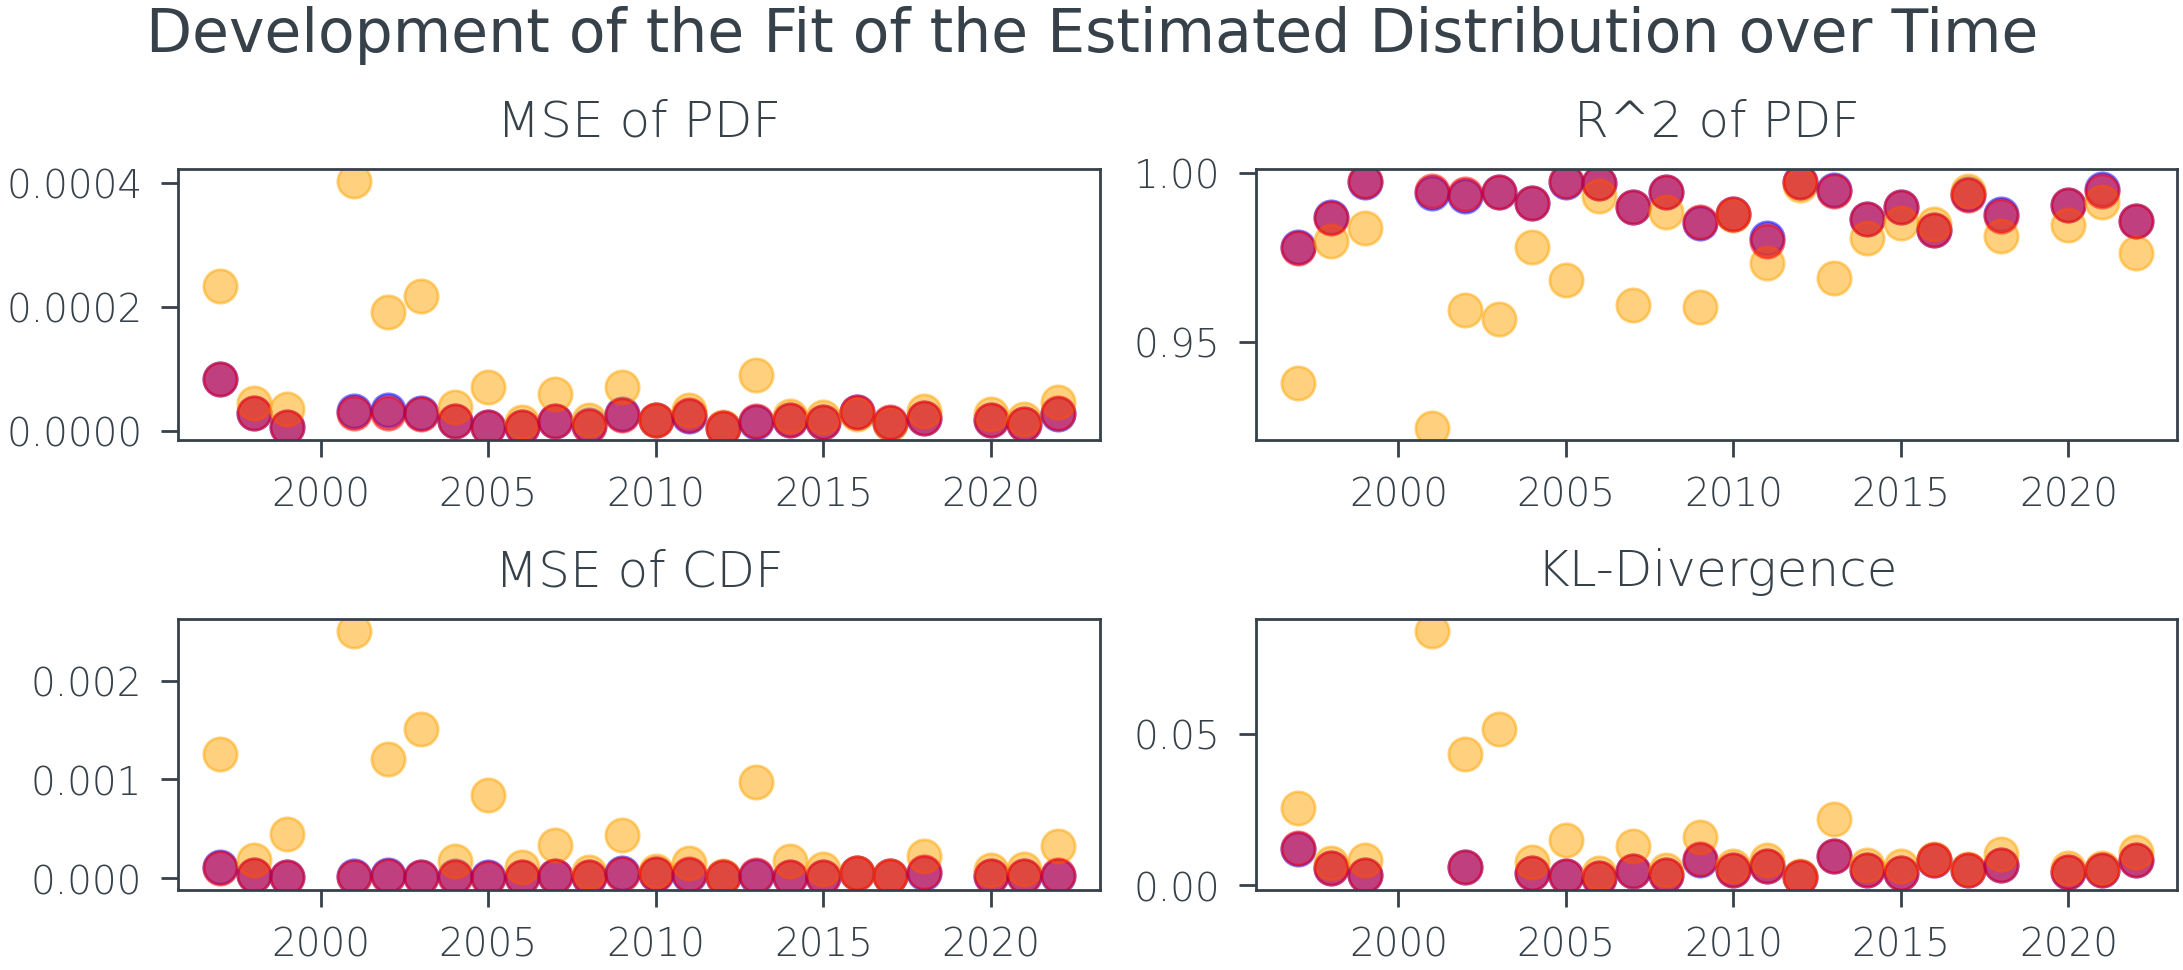

In [120]:
# how does the goodness of fit develop over time (yearly)?

figure, axis = plt.subplots(2, 2)

for y in range(1997, 2023):
    if y==2000 or y==2019:
        continue
    mle_weibull=Weibull.estimate(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    graphical_weibull=Weibull.graphical_estimate(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    epf_weibull=Weibull.epf_estimate(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    #mean_weibull=Weibull(mean_yearly_df.loc[y, ['param_lambda']].item(), mean_yearly_df.loc[y, ['param_beta']].item())#
    mean_weibull=Weibull.estimate(early_df[early_df.index.year==y]['FG'])
    
    fit1= mle_weibull.fit(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    fit2=graphical_weibull.fit(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    fit3=epf_weibull.fit(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])
    fit4=mean_weibull.fit(df[(df['MESS_DATUM'].dt.year == y)]["FF_10_wind"])


    axis[0,0].scatter(y,fit1[0], color='blue', alpha=0.5 , label='MLM') 
    axis[0,0].scatter(y, fit2[0], color='orange', alpha=0.5, label='graphical method')
    axis[0,0].scatter(y, fit3[0], color='red', alpha=0.5, label='epf method')
    #axis[0,0].scatter(y, fit4[0], color='green', alpha=0.5, label='mean method')
    axis[0, 0].set_title("MSE of PDF")

    axis[1,0].scatter(y, fit1[1], color='blue', alpha=0.5) 
    axis[1,0].scatter(y, fit2[1], color='orange', alpha=0.5)
    axis[1,0].scatter(y, fit3[1], color='red', alpha=0.5)
    
    #axis[1,0].scatter(y, fit4[1], color='green', alpha=0.5)
    
    axis[1, 0].set_title("MSE of CDF")

    axis[0,1].scatter(y, fit1[2], color='blue', alpha=0.5) 
    axis[0,1].scatter(y, fit2[2], color='orange', alpha=0.5)
    axis[0,1].scatter(y, fit3[2], color='red', alpha=0.5)
    
    #axis[0,1].scatter(y, fit4[2], color='green', alpha=0.5)
    axis[0, 1].set_title("R^2 of PDF")

    axis[1,1].scatter(y, fit1[4], color='blue', alpha=0.5) 
    axis[1,1].scatter(y, fit2[4], color='orange', alpha=0.5)
    axis[1,1].scatter(y, fit3[4], color='red', alpha=0.5)
    
    #axis[1,1].scatter(y, fit4[4], color='green', alpha=0.5)
    axis[1, 1].set_title("KL-Divergence")

figure.suptitle('Development of the Fit of the Estimated Distribution over Time')
#plt.xlabel('Year')
#plt.ylabel('Fit')
#plt.legend()
plt.show()

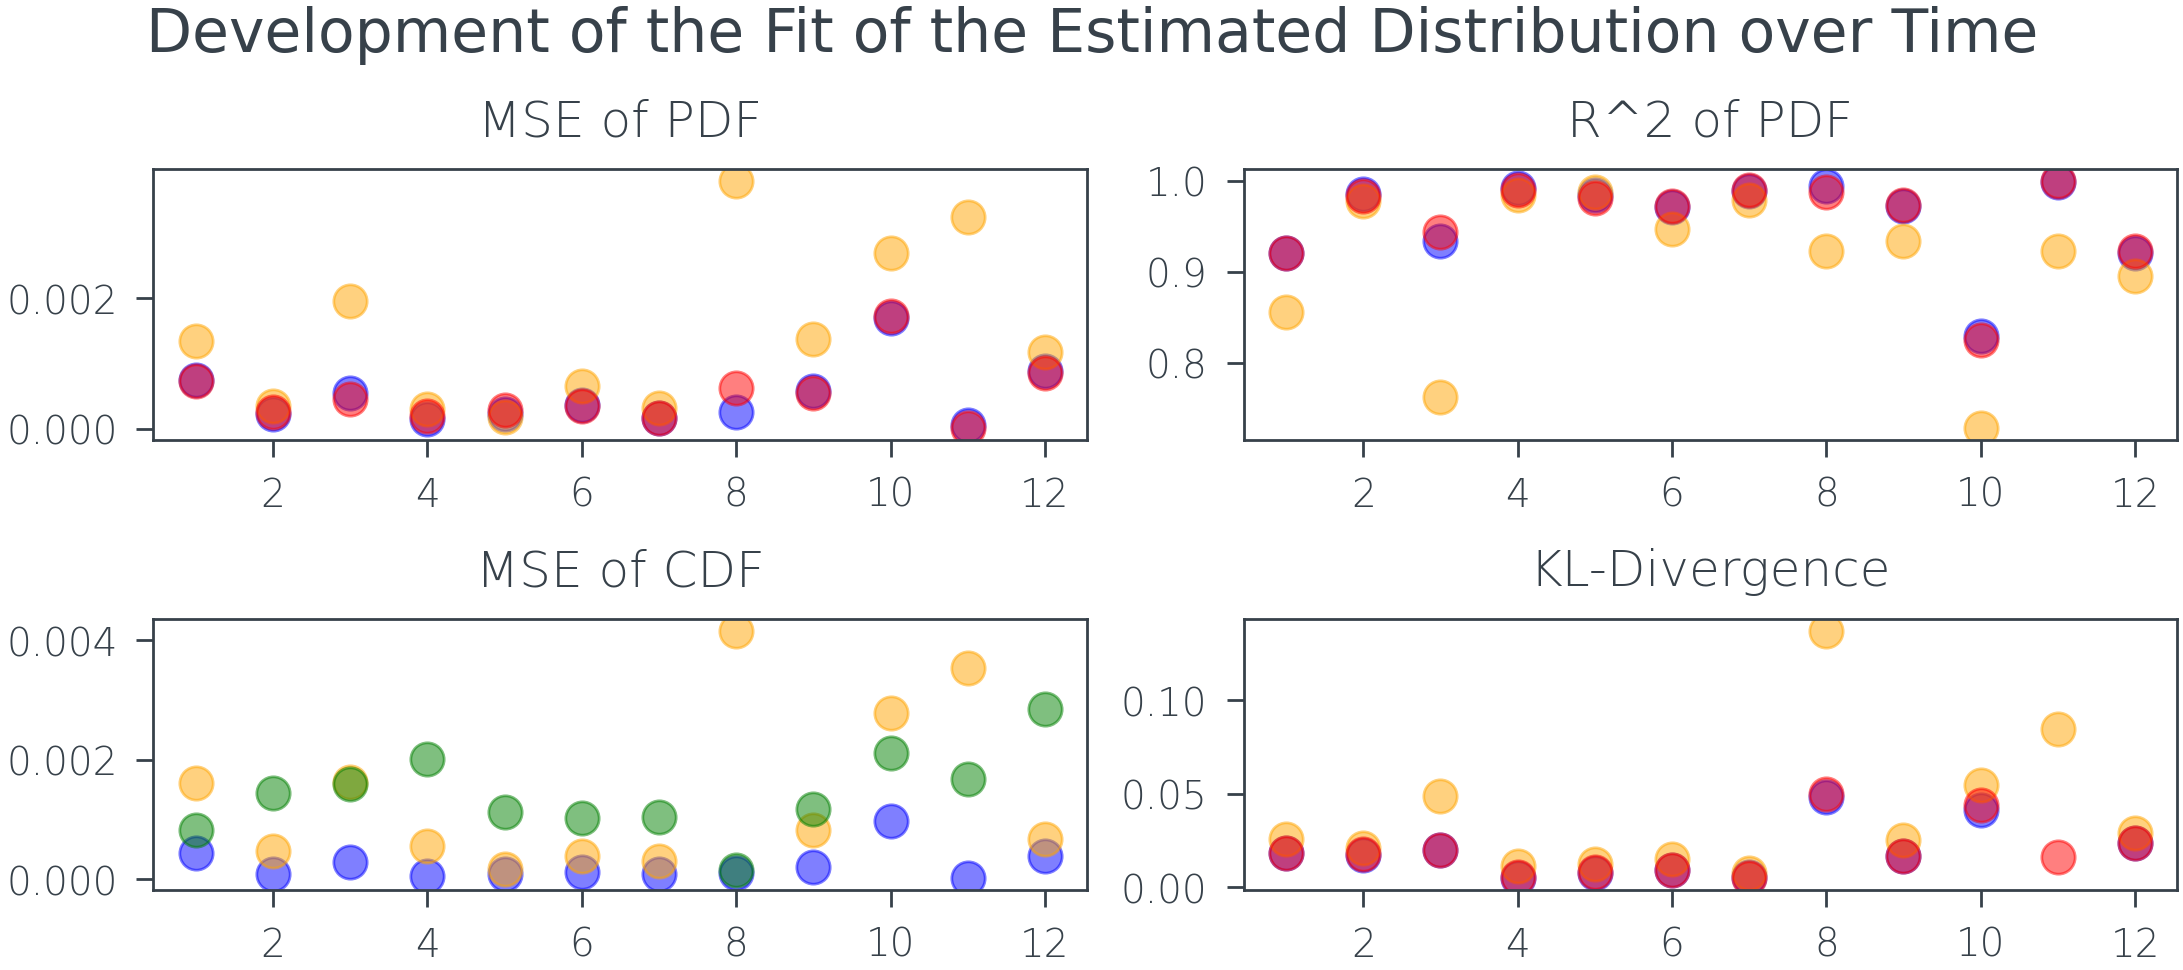

In [118]:
# how does the goodness of fit develop over time (monthly)?

figure, axis = plt.subplots(2, 2)

for m in range(1,13):
    mask=(df['MESS_DATUM'].dt.year == 2001) & (df['MESS_DATUM'].dt.month == m) 
    mask2=(early_df.index.year == 2001)&(early_df.index.month == m)
    mle_weibull=Weibull.estimate(df[mask]["FF_10_wind"])
    graphical_weibull=Weibull.graphical_estimate(df[mask]["FF_10_wind"])
    epf_weibull=Weibull.epf_estimate(df[mask]["FF_10_wind"])

    mean_weibull=Weibull.estimate(early_df[mask2]['FG'])

    
    fit1= mle_weibull.fit(df[mask]["FF_10_wind"])
    fit2=graphical_weibull.fit(df[mask]["FF_10_wind"])
    fit3=epf_weibull.fit(df[mask]["FF_10_wind"])
    fit4=mean_weibull.fit(df[mask]["FF_10_wind"])


    axis[0,0].scatter(m,fit1[0], color='blue', alpha=0.5 , label='MLM') 
    axis[0,0].scatter(m, fit2[0], color='orange', alpha=0.5, label='graphical method')
    axis[0,0].scatter(m, fit3[0], color='red', alpha=0.5, label='epf method')
    #axis[0,0].scatter(m, fit4[0], color='green', alpha=0.5, label='mean method')
    axis[0, 0].set_title("MSE of PDF")

    axis[1,0].scatter(m, fit1[1], color='blue', alpha=0.5) 
    axis[1,0].scatter(m, fit2[1], color='orange', alpha=0.5)
    axis[1,0].scatter(m, fit3[1], color='red', alpha=0.5)
    #axis[1,0].scatter(m, fit4[1], color='green', alpha=0.5)
    
    axis[1, 0].set_title("MSE of CDF")

    axis[0,1].scatter(m, fit1[2], color='blue', alpha=0.5) 
    axis[0,1].scatter(m, fit2[2], color='orange', alpha=0.5)
    axis[0,1].scatter(m, fit3[2], color='red', alpha=0.5)
    
    #axis[0,1].scatter(m, fit4[2], color='green', alpha=0.5)
    axis[0, 1].set_title("R^2 of PDF")

    axis[1,1].scatter(m, fit1[4], color='blue', alpha=0.5) 
    axis[1,1].scatter(m, fit2[4], color='orange', alpha=0.5)
    axis[1,1].scatter(m, fit3[4], color='red', alpha=0.5)
    
    #axis[1,1].scatter(m, fit4[4], color='green', alpha=0.5)
    axis[1, 1].set_title("KL-Divergence")

figure.suptitle('Development of the Fit of the Estimated Distribution over Time')
#plt.xlabel('Year')
#plt.ylabel('Fit')
#plt.legend()
plt.show()

In [122]:
from get_params import snh_test
from get_params import pettitt_test


reduced=pd.DataFrame(yearly_df, index=range(1997, 2019))
plt.plot( reduced.index, snh_test(reduced['Mean']))

plt.axvline(x=2018)
plt.title('Test Statistic of the Standard Normal Homogeneity Test')
plt.show()

plt.plot(mean_df.index, snh_test(mean_df['Mean']))

plt.title('Test Statistic of the Standard Normal Homogeneity Test')
plt.axvline(x=1989)
plt.axvline(x=2018)
plt.show()



plt.plot( reduced.index, pettitt_test(reduced['Mean']))

plt.axvline(x=2018)
plt.show()

plt.plot(mean_df.index, pettitt_test(mean_df['Mean']))
plt.axvline(x=1989)
plt.axvline(x=2018)
plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4132718583.py, line 9)